In [1]:
import pandas as pd
import numpy as np
import os
import string
import datetime
from datetime import timezone
os.getcwd()
import glob
import pytz
import seaborn as sns
import re

In [2]:
def convert_mm(value):
    #length in mm transformed to float
    try:
        new_value = value.replace(' mm','')
        return float(new_value)    
    except AttributeError:
        return np.NaN

In [3]:
def convert_exposure(value):
    #length in mm transformed to float
    try:
        list_string=value.split('/')
        if (len(list_string)==1):
            return float(value)
        else:
            return float(list_string[0])/float(list_string[1])
    except AttributeError:
        #print ('WTF',value)
        return np.NaN
    #return float(0)
        

In [4]:
def extract_vatican(source,place,country):
    #all pictures originate from a Pictures folder, remove the full path
    vatican_strings =['Apostolisch',"Vatikan","Petersdom","Santa Maria Maggiore","Lateran","Paolo fuori le Mura",
                     'Scala Scanta','Triclinium Leoninum','Petersplatz','Campo Santo Teutonico',"Sant' Anna",
                     'Sancta Sanctorum','Palazzo Pontifico','Villa Barberini']
    #including Pictures
    if place=="Rom" or place=="Castel Gandolfo":
        for v in vatican_strings:
            if v in source:
                country='Vatican'
    return country

In [5]:
def remove_full_path(value):
    #all pictures originate from a Pictures folder, remove the full path
    #including Pictures
    try:
        list_string=value.split('/Pictures')
        return list_string[1]
    except AttributeError:
        return np.NaN

In [6]:
def extractCityV2(filename):
    m = re.search(r'(?<=\s-\s)\D+?(,)', filename)
    if m==None:
        print("error in",filename)
    else:
        #print("test",m[0][:-1])
        return m[0][:-1]

In [7]:
def funcDayPeriod(filename):
    search_night=["bei Nacht",'Sternenhimmel',"Mondschein","Mond","Ice and Snow/"]
    search_night_special=["Lumiere","euerwerk","Firework","Freudenfeuer"]
    search_twilight=["bei anbrechender Nacht","Abenddaemmerung","Morgendaemmerung","Sonnenaufgang"]
    if any (x in filename for x in search_night):
        return -1
    elif any(x in filename for x in search_night_special):
         return 0
    elif any(x in filename for x in search_twilight):
        return 3
    elif "bei Sonnenuntergang" in filename:
        return 2
    else:
        return 1

In [8]:
def funcComposite(filename):
    if "Panorama." in filename:
        return 1
    else:
        return 0

In [9]:
def funcMovie(filename):
    search_file_names=[".JPG",".jpg",".JPEG",".jpeg"]
    if any(x in filename for x in search_file_names):
        return 0
    else:
        return 1

In [10]:
def funcTimeZoneCorrectionNYCBias(value,filename,modelname,data_min,data_max):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            #date is ordered by 
            #date_orig = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S") 
            date = value
            if modelname=="SP500UZ":
                if(date>data_min and date<data_max):
                #never changed timezone after getting back from NYC, all messed up
                    date=date+datetime.timedelta(hours=6)
            return date
    except AttributeError:
        return np.NaN

In [11]:
def funcTimeZoneCorrection(value,filename,modelname):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            date = value
            search_names_NYC_time_zone=["- Philadelphia,","New York City,","Newark,","Washington Airport"]
            search_names_London_time_zone_CANON600D=["Dublin & Nordirland/P","120830-120909 - Portugal/","Suedengland/","141212-141214 - London/","Greater London"]
            search_names_Istanbul_time_zone_CANON600D=["41023-141027 - Istanbul/","150828-150912 Sankt Petersburg/"]
            search_names_pacific_time_zone_CANON600D=["150613 - Los Angeles/","USA/P818"," - Grand Canyon Village, "," - Boulder City, "," - Las Vegas, "]
            search_names_China_time_zone_CANON80D=["180101 China/","/171230 Shanghai"," - China, "]
            search_names_EastEurope_time_zone_CANON80D=["170603 Athen/","171006 Tallinn ","/170414 Kiev"," - Tuerkei, "," - Irak, "," - Kuwait"," - Qatar, "]
            search_names_London_time_zone_CANON80D=[" - Saudi-Arabien,","/190413-190417 Suedostengland/"," - United Kingdom - ","/171110 Marrakesch/","170915 London/P","/180602 UK/"]
            search_names_Iceland_time_zone_CANON80D=[" - Island, ","/180328 Island/"]
            search_names_Gulf_time_zone_CANON80D=[" - Island, "," - Dubai, "]
            search_names_Pakistan_time_zone_CANON80D=[" - Pakistan, "]
            search_names_Korea_time_zone_CANON80D=[" - Paju, "," - Suwon, "," - Seoul, "," - Busan,"," - Incheon, "," - Gyeongju, "," - Gwanju, "]
            if modelname=="SP500UZ":
                hour_bias=0
                data_max_olympus=datetime.datetime.now()
                date_max_olympus=datetime.date(2008,9,1)
                if(date.date()<date_max_olympus):
                    hour_bias=24
                #no change of default time, thus London time is an hour too late
                if "London/P" in filename:  
                    date=date-datetime.timedelta(hours=1)+datetime.timedelta(hours=hour_bias)
                    return date
                elif any(x in filename for x in search_names_NYC_time_zone):
                    date=date-datetime.timedelta(hours=6)+datetime.timedelta(hours=hour_bias)
                    return date
                elif " Chicago - Edit2012/P" in filename:
                    date=date-datetime.timedelta(hours=7)+datetime.timedelta(hours=hour_bias)
                    return date    
                else:
                    value_new=date+datetime.timedelta(hours=hour_bias)
                    return value_new
            if modelname=="Canon EOS 600D":
                #all of EOS600D done including 2015
                if any(x in filename for x in search_names_London_time_zone_CANON600D):
                    date=date-datetime.timedelta(hours=1)
                    return date
                elif any(x in filename for x in search_names_Istanbul_time_zone_CANON600D):
                    date=date+datetime.timedelta(hours=1) 
                    return date
                elif any(x in filename for x in search_names_pacific_time_zone_CANON600D):
                    date=date-datetime.timedelta(hours=9)
                    return date
                elif "- Chicago, " in filename:
                    date=date-datetime.timedelta(hours=7)
                    return date
                elif " - Washington D.C., " in filename:
                    date=date-datetime.timedelta(hours=6)
                    return date
                elif "/160813 - USA/" in filename:
                    #remaining 2016 US trip times
                    date=date-datetime.timedelta(hours=8)
                    return date
                elif "161205 - Japan/" in filename:
                    date=date+datetime.timedelta(hours=7)
                    return date
                else:
                    #change to default summer time
                    return date
            if modelname=="Canon PowerShot S110":  
                 #all running on summer time
                if any(x in filename for x in search_names_London_time_zone_CANON600D): 
                    date=date-datetime.timedelta(hours=2)
                    return date
                elif "41023-141027 - Istanbul/" in filename:
                    #for Istanbul timezone was not aligned with CANON EOS600D
                    date=date-datetime.timedelta(hours=1)
                    return date
                elif "150613 - Los Angeles/" in filename:
                    date=date-datetime.timedelta(hours=10)
                    return date
                elif "/2016/" in filename:
                    if "161205 - Japan/" in filename:
                        date=date+datetime.timedelta(hours=6)
                        return date
                    else:
                        #change to default summer time
                        date=date-datetime.timedelta(hours=1)
                        return date
                else:
                    #change to default summer time
                    date=date-datetime.timedelta(hours=1)
                    return date
            if modelname=="Canon EOS 80D":
                if any(x in filename for x in search_names_China_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=6)
                    return date
                elif any(x in filename for x in search_names_EastEurope_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=1)
                    return date
                elif any(x in filename for x in search_names_London_time_zone_CANON80D):
                    date=date-datetime.timedelta(hours=1)
                    return date
                elif " - Groenland" in filename:
                    date=date-datetime.timedelta(hours=4)
                    return date
                elif any (x in filename for x in search_names_Iceland_time_zone_CANON80D):
                    date=date-datetime.timedelta(hours=2)
                    return date
                elif "/170609 USA/" in filename:
                    date=date-datetime.timedelta(hours=8)
                    return date
                elif any(x in filename for x in search_names_Gulf_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=2)
                    return date
                elif any(x in filename for x in search_names_Pakistan_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=3)
                    return date
                elif any(x in filename for x in search_names_Korea_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=7)
                    return date
                else:
                    #always on summer time
                    return date
    except AttributeError:
        return np.NaN

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


dataframe_list=[]

datamax=datetime.datetime.now()
datamin=datetime.datetime.now()


"""    
columns_to_keep=['SourceFile','Aperture','AspectRatio','AutoISO','BaseISO','BitsPerSample',
                'ColorSpace','ColorTemperature','Contrast','DateTimeOriginal','DateTimeOriginal'
                    'ExposureTime','FileName','Flash','FocalLength','FocalLength35efl','ImageSize',
                    'ImageWidth','ISO','Lens','Lens35efl','LightValue','MaxAperture','MinAperture','MinFocalLength',
                     'Model','Orientation','PictureStyle','Quality','RedBalance','ShutterSpeed',
                    'TargetAperture','TimeZone','TimeZoneCity','WB_RGGBLevels','WB_RGGBLevelsAsShot',
                    'WBBracketMode','WhiteBalance','WhiteBalanceBlue','WhiteBalanceRed','BlueBalance']
"""

for input in range(2006,2022):
    #print("get to year",input)
    file_name=("outputEXIFcsvsFullInfo/PhotoEXIFDataFull_%s.csv"%(str(input)))
#    df=pd.read_csv(file_name)
#    df=df.dropna(subset=['BitsPerSample'])
    df_test=pd.read_csv(file_name, encoding= 'unicode_escape')
    df_test=df_test.dropna(subset=['BitsPerSample'])
#for c in df_test.columns:
#    print("col",c,df_test[c].isna().sum(),df_test.shape)

    columns_to_keep=['SourceFile','Aperture','ApertureValue','BitsPerSample','BlueBalance','ColorSpace','ColorTempAsShot','Contrast',
                 'DateTimeOriginal','ExposureTime','FileName','Flash','FlashActivity','FNumber','FocalLength','CreateDate',
                 'FocalLength35efl','ImageSize','ImageWidth','ISO','LightValue','Model','Orientation',
                 'Quality','ShutterSpeed','ShutterSpeedValue','WB_RGGBLevelsAsShot','WhiteBalance']
    #df_test=df_test[columns_to_keep]
    df_test=df_test[df_test.columns.intersection(columns_to_keep)]
    df_test["Place"]=df_test.apply(lambda x: extractCityV2(x['SourceFile']), axis=1)
    df_test['SourceFile']=df_test['SourceFile'].apply(remove_full_path)    
    df_test['FocalLength']=df_test['FocalLength'].apply(convert_mm) 
    df_test['ExposureTime']=df_test['ExposureTime'].apply(convert_exposure)
    df_test=df_test.replace({'DateTimeOriginal': {'0000:00:00 00:00:00': '2006:01:10 15:20:30'}})
    df_test['DateTimeOriginal']=pd.to_datetime(df_test['DateTimeOriginal'],format='%Y:%m:%d %H:%M:%S')
    df_test['year']=int(input)
    df_test['dayperiod']=df_test.apply(lambda x: funcDayPeriod(x['SourceFile']), axis=1)
    df_test['CompositePhoto']=df_test.apply(lambda x: funcComposite(x['SourceFile']), axis=1)
    df_test['Movie']=df_test.apply(lambda x: funcMovie(x['SourceFile']), axis=1)
    df_test.rename(columns={'DateTimeOriginal':'Date','FocalLength':'FocalLength in mm'},inplace=True) 
    df_test['Date']=df_test.apply(lambda x: funcTimeZoneCorrection(x['Date'],x['SourceFile'],x['Model']), axis=1)
    #total_rows=df_test['SourceFile'].count()
    if(input==2009 or input ==2010):
        if input==2009:
            test=df_test.loc[df_test['SourceFile'].str.contains("P7080022 - New York City")]
            datamin=df_test.at[test.index.values.astype(int)[0],"Date"]   
            print("correction should begin somewhere here 2009",test,"index is",test.index.values.astype(int)[0],datamin)
            df_test['Date']=df_test.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
        elif input==2010:    
            test=df_test.loc[df_test['SourceFile'].str.contains("P8270068 - Le Locle, unterirdische Muehlen")]
            print("correction should end somewhere here 2010",test,"index is",test.index.values.astype(int)[0],datamax)
            datamax=df_test.at[test.index.values.astype(int)[0],"Date"] 

            df_test['Date']=df_test.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
    dataframe_list.append(df_test)
#df = pd.DataFrame(dataframe_list, columns=columns_to_keep)
#print(dataframe_list[0])

#combine_all_data=pd.DataFrame(dataframe_list[0]) 
#dataframe_list.pop(0)
#for data in dataframe_list:
#        #print(data.head)
#    combine_all_data=pd.concat([combine_all_data,data],ignore_index=True,sort=False)


#combine_all_data.to_csv("pictureData/PhotoEXIFDataStripped_2006_2021.csv")
#combine_all_data


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,4,6,7,8,9,12,13,14,15,21,22,24,34,40,42,44,45,46,48,49,51,71,79,81,82,83,84,86,87,94,104,110,111,112,115,122,130,136,140,142,143,145,149,150,151,152,158,160,162,163,164,165,166,167,169,177,195,204,205,206,209,212,213,216,218,219,220,223,226,239,240,241,242,245,246,247,250,256,257,262,265,288,290,295,300,301,308,310,319,321,322,325,326,327,328,332,335,336,337,338,339,340,345,347,349,353,354,355,357,364,365,366,367,368,369,370,371,372,373,374,375,376,394,395) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,3,6,7,10,11,14,15,19,21,23,24,29,30,34,36,38,39,40,42,43,45,46,48,49,51,53,54,58,59,60,61,63,66,67,70,71,72,73,76,77,78,79,80,81,82,85,86,87,88,89,90,91,107,114,116,125,127,129,130,131,

correction should begin somewhere here 2009                                              SourceFile  Aperture  \
3277  /2009/090623 USA CTEQ09/090703 New York City/P...       3.0   

      ApertureValue  BitsPerSample ColorSpace Contrast           CreateDate  \
3277            NaN            8.0       sRGB   Normal  2009:07:08 19:48:04   

                    Date  ExposureTime  \
3277 2009-07-08 13:48:04        0.0125   

                                               FileName  ...  \
3277  P7080022 - New York City, Lufthansa Boeing 747...  ...   

              Orientation      Quality  ShutterSpeed ShutterSpeedValue  \
3277  Horizontal (normal)  HQ (Normal)          1/80               NaN   

     WhiteBalance          Place  year  dayperiod CompositePhoto Movie  
3277         Auto  New York City  2009          1              0     0  

[1 rows x 29 columns] index is 3277 2009-07-08 13:48:04


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,3,4,5,6,7,8,11,13,21,23,25,26,40,41,43,45,46,47,49,50,52,54,55,73,74,76,78,79,80,90,93,97,99,109,114,116,117,118,119,136,144,146,148,149,151,154,155,159,161,163,165,166,167,168,169,170,171,172,179,184,185,186,187,189,195,212,213,215,217,223,224,225,227,228,231,246,249,252,260,261,263,271,277,278,279,285,290,307,309,312,314,315,316,317,320,321,322,344,345,371,372,373,375,384,388,398,399,400,401,402,406,409,415,416,417,418,422,423,425,427) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


correction should end somewhere here 2010                                              SourceFile  Aperture  \
5389  /2010/100827 Jura/P8270068 - Le Locle, unterir...       2.8   

      ApertureValue  BitsPerSample ColorSpace Contrast           CreateDate  \
5389            NaN            8.0       sRGB   Normal  2010:08:27 16:15:55   

                    Date  ExposureTime  \
5389 2010-08-27 16:15:55           2.5   

                                            FileName  ...   Orientation  \
5389  P8270068 - Le Locle, unterirdische Muehlen.JPG  ...  Rotate 90 CW   

      Quality  ShutterSpeed ShutterSpeedValue WhiteBalance     Place  year  \
5389      NaN           2.5               NaN         Auto  Le Locle  2010   

      dayperiod CompositePhoto Movie  
5389          1              0     0  

[1 rows x 29 columns] index is 5389 2021-05-30 21:51:55.774388


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,2,5,6,7,9,15,16,17,19,29,32,37,38,39,41,42,44,45,54,56,61,63,64,68,74,75,76,78,80,82,83,84,92,98,100,101,102,111,114,122,136,138,139,140,142,149,151,153,156,157,158,159,160,165,167,170,171,172,173,174,180,184,189,192,195,202,208,209,212,213,214,215,219,221,222,223,226,227,228,231,239,242,256,257,260,261,264,266,273,278,279,280,281,283,284,285,287,288,290,293,307,312,323,325,332,333,344,345,348,350,355,359,360,361,362,367,370,374,375,381,387,389,390,391,400) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,5,12,15,16,22,23,28,32,34,49,50,51,52,64,65,70,73,74,98,109,118,122,131,134,135,136,137,138,139,140,145,157,158,161,162,179,180,191,199,200,212,214,215,219,220,225,230,232,237,240,241,2

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (19,20,26,33,40,55,73,87,90,91,111,134,144,169,170,186,187,217,221,228,229,231,232,243,256,272,274,275,276,277,295,296,321,329,340,341,345,346,347) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [13]:
dataframe_list_an=[]

for input_an in range(1995,2006):
    #print("get to year",input)
    file_name_an=("outputEXIFcsvsFullInfo/PhotoEXIFDataFull_%s.csv"%(str(input_an)))
#    df=pd.read_csv(file_name)
#    df=df.dropna(subset=['BitsPerSample'])
    df_an=pd.read_csv(file_name_an, encoding= 'unicode_escape')
    print(df_an.columns)
    df_an=df_an.dropna(subset=['BitsPerSample'])
    columns_to_keep_an=['SourceFile','FileName','ImageWidth']
    df_an=df_an[df_an.columns.intersection(columns_to_keep_an)]
    df_an["Place"]=df_an.apply(lambda x: extractCityV2(x['SourceFile']), axis=1)
    df_an['SourceFile']=df_an['SourceFile'].apply(remove_full_path)    
    df_an['year']=int(input_an)
    df_an['dayperiod']=df_an.apply(lambda x: funcDayPeriod(x['SourceFile']), axis=1)
                        
    dataframe_list_an.append(df_an)
    dataframe_list.append(df_an)
#df = pd.DataFrame(dataframe_list, columns=columns_to_keep)
#print(dataframe_list[0])

#combine_all_data_an=pd.DataFrame(dataframe_list_an[0]) 
#dataframe_list_an.pop(0)
#for data in dataframe_list_an:
#        #print(data.head)
#    combine_all_data_an=pd.concat([combine_all_data_an,data],ignore_index=True,sort=False)


#combine_all_data_an.to_csv("pictureData/PhotoEXIFDataStripped_1995_2005.csv")
#combine_all_data_an

combine_all_data=pd.DataFrame(dataframe_list[0]) 
dataframe_list.pop(0)
for data in dataframe_list:
        #print(data.head)
    combine_all_data=pd.concat([combine_all_data,data],ignore_index=True,sort=False)


combine_all_data.to_csv("pictureData/PhotoEXIFDataStripped_1995_2021.csv")
combine_all_data

Index(['SourceFile', 'ExifToolVersion', 'FileName', 'Directory', 'FileSize',
       'FileModifyDate', 'FileAccessDate', 'FileInodeChangeDate',
       'FilePermissions', 'FileType', 'FileTypeExtension', 'MIMEType',
       'JFIFVersion', 'ResolutionUnit', 'XResolution', 'YResolution',
       'ExifByteOrder', 'ImageWidth', 'ImageHeight', 'EncodingProcess',
       'BitsPerSample', 'ColorComponents', 'YCbCrSubSampling', 'ImageSize',
       'Megapixels'],
      dtype='object')
Index(['SourceFile', 'ExifToolVersion', 'FileName', 'Directory', 'FileSize',
       'FileModifyDate', 'FileAccessDate', 'FileInodeChangeDate',
       'FilePermissions', 'FileType', 'FileTypeExtension', 'MIMEType',
       'JFIFVersion', 'ResolutionUnit', 'XResolution', 'YResolution',
       'ExifByteOrder', 'ImageWidth', 'ImageHeight', 'EncodingProcess',
       'BitsPerSample', 'ColorComponents', 'YCbCrSubSampling', 'ImageSize',
       'Megapixels'],
      dtype='object')
Index(['SourceFile', 'ExifToolVersion', 'FileNam

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,year,dayperiod,CompositePhoto,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,2006,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,2006,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,2006,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,2006,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,2006,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108815,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090005 - Diavolezza, Berghaus.jpg",NaN,...,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108816,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090007 - Diavolezza, Berge.jpg",NaN,...,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108817,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110002 - Diavolezza, im Berghaus.jpg",NaN,...,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108818,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110006 - Diavolezza, beim Jassen.jpg",NaN,...,2005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
combine_all_data[combine_all_data["year"]==2020]["Place"].nunique()

96

In [15]:
dict_place_to_country = {'Frankreich': 'France', 'Chamonix': 'France', 'Montenvers': 'France', 'Les Houches': 'France', 'Basel': 'Switzerland',
       'London': 'United Kingdom', 'Windsor': 'United Kingdom', 'Meyrin': 'Switzerland', 'Genf': 'Switzerland', 'Kuessaberg': 'Germany',
       'Lauchringen': 'Germany', 'Goerwihl': 'Germany', 'Tiengen': 'Germany', 'Zuerich':'Switzerland', 'Schweiz':'Switzerland',
       'Zermatt':'Switzerland', 'Sion':'Switzerland', 'St Niklaus':'Switzerland', 'Randa':'Switzerland', 'Singen': 'Germany', 'Birnau': 'Germany',
       'Meersburg': 'Germany', 'Cessy':'France', 'Carouge':'Switzerland', 'Lausanne':'Switzerland', 'Zurzach':'Switzerland',
       'Einsiedeln':'Switzerland', 'Schwyz':'Switzerland', 'Montreux':'Switzerland', 'Aarau':'Switzerland', 'Veytaux':'Switzerland',
       'Villeneuve':'Switzerland', 'Naefels':'Switzerland', 'St Gallen':'Switzerland', 'Dresden': 'Germany', 'Meissen': 'Germany',
       'Moritzburg': 'Germany', 'Annecy': 'France', 'Frankfurt': 'Germany', 'Philadelphia': 'USA', 'Madrid':'Spain',
       'El Escorial':'Spain', 'Segovia':'Spain', 'Lauterbrunnen':'Switzerland',
       'Grindelwald':'Switzerland', 'Fieschertal':'Switzerland', 'Nuernberg': 'Germany', 'St Blasien': 'Germany', 'Sarnen':'Switzerland',
       'Neuchatel':'Switzerland', 'Solothurn':'Switzerland', 'Bern':'Switzerland', 'Konstanz': 'Germany', 'Reichenau': 'Germany',
       'Rheinau':'Switzerland', 'Morges': 'Switzerland', 'Switzerland': 'France', 'Paris': 'France', 'Hebron':'USA',
       'Madison': 'USA', 'Chicago': 'USA', 'New York City': 'USA', 'Jersey City': 'USA', 'Getafe':'Spain',
       'Toledo':'Spain', 'St Maurice':'Switzerland', 'St Leonhard':'Switzerland', 'Brig':'Switzerland',
       'Karlsruhe': 'Germany', 'Mainz': 'Germany', 'Speyer': 'Germany', 'Frankfurt': 'Germany', 'Mannheim': 'Germany', 'Worms': 'Germany',
       'Heidelberg': 'Germany', 'Wutach': 'Germany', 'Innsbruck':'Austria', 'Telfs':'Austria',
       'Feldkirch':'Austria', 'Coppet':'Switzerland', 'Schaffhausen':'Switzerland', 'Sargans':'Switzerland', 'Breitenfeld':'Germany',
       'Oesterreich':'Austria', 'Fribourg':'Switzerland', 'Brienz':'Switzerland', 'Meiringen':'Switzerland', 'Interlaken':'Switzerland',
       'Stechelberg':'Switzerland', 'Zweitluetschinen':'Switzerland', 'Thun':'Switzerland',
       'Argentiere': 'France', 'Luzern':'Switzerland', 'Rosenlaui':'Switzerland', 'Fiesch':'Switzerland', 'Riederalp':'Switzerland',
       'Oberwald':'Switzerland', 'Realp':'Switzerland', 'Hasel': 'Germany', 'Hechingen': 'Germany', 'Rottweil': 'Germany',
       'Donaueschingen': 'Germany', 'Versailles': 'France', 'Chartres': 'France', 'Fontainebleau': 'France',
       'St Denis': 'France', 'Vincennes': 'France', 'Puteaux': 'France', 'Reims': 'France', 'Les Brenets':'Switzerland',
       'Le Locle':'Switzerland', 'Les Diablerets':'Switzerland', 'Saas Fee':'Switzerland', 'Saas Grund':'Switzerland', 'Visp':'Switzerland',
       'Ascona':'Switzerland', 'Locarno':'Switzerland', 'Bellinzona':'Switzerland', 'Lugano':'Switzerland', 'Como': 'Italy', 'Engelberg':'Switzerland',
       'Martigny':'Switzerland', 'Tour':'France', 'Hoechenschwand': 'Germany', 'Hohenschwangau': 'Germany', 'Fuessen': 'Germany',
       'Steingaden': 'Germany', 'Schwangau': 'Germany', 'Muenchen': 'Germany', 'Ehrwald':'Austria',
       'Garmisch-Partenkirchen': 'Germany', 'Ettal': 'Germany', 'Grainau': 'Germany', 'Ulm': 'Germany', 'Augsburg': 'Germany',
       'Saint Denis': 'France', 'Mailand':'Italy', 'Flegere': 'France', 'Les Houches': 'France', 'Charmonix': 'France',
       'Breitnau': 'Germany', 'Freiburg': 'Germany', 'Feldberg':'Germany', 'Vernayaz':'Switzerland',
       'Vallorbe':'Switzerland', 'Lyon': 'France', 'Stein':'Switzerland', 'Bad Saeckingen': 'Germany', 'Leibstadt':'Switzerland',
       'Mainau': 'Germany', 'Gadmen':'Switzerland', 'Saas Almagell':'Switzerland', 'Ludwigsburg': 'Germany', 'Hintertux': 'Austria',
       'Zell am Ziller': 'Austria', 'Wuerzburg': 'Germany', 'Bamberg': 'Germany', 'Bad Staffelstein': 'Germany',
       'Banz': 'Germany', 'Coburg': 'Germany', 'Pommersfelden': 'Germany', 'Kloten':'Switzerland', 'Wien': 'Austria', 'Rust': 'Germany',
       'Batavia': 'USA', 'Newark': 'USA', 'USA': 'USA', 'Ferney-Voltaire': 'France', 'Vevey':'Switzerland',
       'Chambessy':'Switzerland', 'Deutschland': 'Germany', 'Karlstejn':'Czech Republic', 'Prag':'Czech Republic', 'Spiez':'Switzerland',
       'Oberhofen':'Switzerland', 'Hilterfingen':'Switzerland', 'Leukerbad':'Switzerland', 'Leuk':'Switzerland', 'Berlin': 'Germany',
       'Potsdam': 'Germany', 'Unteruhldingen': 'Germany', 'Spanien':'Spain', 'Oeiras':'Portugal',
       'Lissabon':'Portugal', 'Portugal':'Portugal', 'Belem':'Portugal', 'Sintra':'Portugal', 'Mafra':'Portugal', 'Queluz':'Portugal',
       'Coimbra':'Portugal', 'Tomar':'Portugal', 'Cascais':'Portugal', 'Porto':'Portugal', 'Guttannen':'Switzerland', 'Krakau':'Poland',
       'Warschau':'Poland', 'Chenonceau': 'France', 'Chaumont': 'France', 'Cheverny': 'France',
       'Blois': 'France', 'Amboise': 'France', 'Orleans': 'France', 'Chaumont-sur-Loire': 'France', 'Chambord': 'France',
       'Vezelay': 'France', 'Cluny': 'France', 'Amsterdam':'Netherlands', 'Apeldoorn':'Netherlands', 'Den Haag':'Netherlands',
       'Soestdijk':'Netherlands', 'Satigny':'Switzerland', 'Prevessin':'France', 'Hermance':'Switzerland',
       'Italien':'Italy', 'Tivoli':'Italy', 'Rom':'Italy', 'Lido Azzuro':'Italy',
       'Ostia':'Italy', 'Grandvaux':'Switzerland', 'Thoiry': 'France', 'Riedern am Wald': 'Germany',
       'Venedig':'Italy', 'Prangins':'Switzerland', 'Compiegne': 'France', 'Chantilly': 'France', 'Malmaison': 'France',
       'Maisons-Lafitte': 'France', 'Champs-sur-Marne': 'France', 'Vaux-le-Vicomte': 'France',
       'Strassburg': 'France', 'Ayze': 'France', 'Stockholm':'Sweden', 'Kopenhagen':'Denmark', 'Drottningholm':'Sweden',
       'Ulriksdal':'Sweden', 'Soedertalje Sued':'Sweden', 'Mariefred':'Sweden', 'Skokloster':'Sweden',
       'Rosersberg':'Sweden', 'Helsingor':'Denmark', 'Hillerod':'Denmark', 'Fredensborg':'Denmark', 'Stresa':'Italy',
       'Baveno':'Italy', 'Domodossola':'Italy', 'Kempten':'Germany', 'Rosenheim':'Germany', 'Prien':'Germany',
       'Herrenchiemsee':'Germany', 'Landshut':'Germany', 'Schleissheim':'Germany', 'Sigmaringen':'Germany',
       'Beuron':'Germany', 'Bovernier ': 'Switzerland', 'Istanbul': 'Turkey', 'Serbien': 'Serbia', 'Kroatien': 'Croatia',
       'Frankreich & Italien': 'France', 'Totland': 'United Kingdom', 'Bath': 'United Kingdom', 'Eton': 'United Kingdom', 'Portsmouth': 'United Kingdom',
       'Hatfield': 'United Kingdom', 'Seaford': 'United Kingdom', 'Brighton': 'United Kingdom', 'Ryde': 'United Kingdom', 'East Cowes': 'United Kingdom',
       'Yarmouth': 'United Kingdom', 'Dover': 'United Kingdom', 'Lymington': 'United Kingdom', 'Woodstock': 'United Kingdom', 'Oxford': 'United Kingdom', 'UK': 'United Kingdom',
       'Rochester': 'United Kingdom', 'Canterbury': 'United Kingdom', 'Amesbury': 'United Kingdom', 'Salisbury': 'United Kingdom',
       'Devinska Nova Ves':'Slovakia', 'Goedoello':'Hungary', 'Eisenstadt':'Austria', 'Neusiedl am See':'Austria',
       'Fertoed':'Hungary', 'Bratislava':'Slovakia', 'Devin':'Slovakia', 'Schlosshof':'Austria', 'Budapest':'Hungary',
       'Bologna':'Italy', 'Florenz':'Italy', 'Pisa':'Italy', 'Siena':'Italy', 'Montalchez':'Switzerland', 'Genthod':'Switzerland',
       'Russin':'Switzerland', 'Bourdigny-Dessous':'Switzerland', 'Monza':'Italy', 'Sevilla':'Spain', 'Granada':'Spain',
       'Cordoba':'Spain', 'La Granja':'Spain', 'Aranjuez':'Spain', 'El Pardo':'Spain', 'Passy': 'France', 'Monaco': 'Monaco',
       'Beaulieu-sur-Mer': 'France', "Cap d'Ail": 'France', 'Nizza': 'France', 'Villefranche-sur-Mer': 'France',
       'Irland': 'Ireland', 'Los Angeles': 'USA', 'Long Beach': 'USA', 'Pasadena': 'USA',
       'Pacific Palisades': 'USA', 'Mont-Saint-Michel':'France', 'Pompei':'Italy',
       'Ottaviano':'Italy', 'Torre Annunziata':'Italy', 'Neapel':'Italy', 'Pozzuoli':'Italy', 'Portici':'Italy',
       'Castellammare di Stabia':'Italy', 'Caserta':'Italy', 'Erding': 'Germany', 'Niederlande':'Netherlands',
       'Kronstadt':'Russia', 'Peterhof':'Russia', 'Strelna':'Russia', 'St Petersburg':'Russia', 'Lomonosow':'Russia',
       'Pawlovsk':'Russia', 'Gatchina':'Russia', 'Moskau':'Russia', 'Olgino':'Russia', 'Puschkin':'Russia', 'Hamburg': 'Germany',
       'Rudolstadt': 'Germany', 'Schwerin': 'Germany', 'Luebeck': 'Germany', 'Weimar': 'Germany', 'Erfurt': 'Germany', 'Fulda': 'Germany',
       'Jena': 'Germany', 'Gotha': 'Germany', 'Taesch':'Switzerland', 'Melk':'Austria', 'Wildbad Kreuth': 'Germany', 'Tegernsee': 'Germany',
       'Goettweig':'Austria', 'Passau': 'Germany', 'Salzburg':'Austria', 'Colmar':'France', 'Catania':'Italy',
       'Piazza Armerina':'Italy', 'Cefalu':'Italy', 'Monreale':'Italy', 'Palermo':'Italy', 'Calatafimi':'Italy',
       'Castellammare del Golfo':'Italy', 'Selinunt':'Italy', 'Realmonte':'Italy', 'Agrigent':'Italy',
       'Comiso':'Italy', 'Noto':'Italy', 'Syrakus':'Italy', 'Nicolosi':'Italy', 'Barcelona':'Spain',
       'Saragossa':'Spain', 'Gruyeres':'Switzerland', 'Broc':'Switzerland', 'Waldshut': 'Germany', 'Venaria Reale':'Italy',
       'Turin':'Italy', 'Racconigi':'Italy', 'Aglie':'Italy', 'Nichelino':'Italy', 'Monterosso al Mare':'Italy',
       'Riomaggiore':'Italy', 'Pollein':'Italy', 'Genua':'Italy', 'Manarola':'Italy', 'Corniglia':'Italy',
       'Vernazza':'Italy', 'San Bernardino':'Italy', 'Aostatal':'Italy', 'Courmayeur':'Italy',
       'Santander':'Spain', 'Bilbao':'Spain', 'Puente Viesgo':'Spain', 'Burgos':'Spain', 'Somo':'Spain',
       'Le Chable':'Switzerland', 'Verbier':'Switzerland', 'Hermence':'Switzerland', 'Little Elm':'USA', 'Dagenham': 'United Kingdom',
       'Sligo': 'Ireland', 'Dartford':'United Kingdom', 'Kanada':'Canada', 'Lake Dalles':'USA', 'Dallas':'USA',
       'Lewisville':'USA', 'Fort Worth':'USA', 'Longford': 'Ireland', 'Frisco':'USA', 'Bordeaux': 'France',
       'Saint-Gervais-les-Bains': 'France', 'Ravenna':'Italy', 'Classe':'Italy', 'Padua':'Italy',
       'Santiago de Compostela':'Spain', 'Koeln': 'Germany', 'Duesseldorf': 'Germany',
       'Friedrichssegen': 'Germany', 'Limburg': 'Germany', 'Bruehl': 'Germany', 'Bonn': 'Germany', 'Mantua':'Italy', 'Verona':'Italy',
       'Russland': 'Russia', 'Tokio':'Japan', 'Morioka':'Japan', 'Hiraizumi':'Japan', 'Japan':'Japan', 'Nikko':'Japan',
       'Utsunomiya':'Japan', 'Kyoto':'Japan', 'Himeji':'Japan', 'Nara':'Japan', 'Ikaruga':'Japan', 'Hiroshima':'Japan',
       'Fukuyama':'Japan', 'Uji':'Japan', 'China':'China', 'Hatsukaichi':'Japan', 'Osaka':'Japan', 'Springdale':'USA',
       'Las Vegas': 'USA', 'Bruessel': 'Belgium', 'Aurora': 'USA', 'Boulder City': 'USA',
       'Grand Canyon Village': 'USA', 'Tusayan': 'USA', 'Cameron': 'USA', 'Page': 'USA', 'Kaibito': 'USA',
       'Oljato-Monument Valley': 'USA', 'Halchita': 'USA', 'Mexican Hat': 'USA', 'Bluff': 'USA',
       'Aneth': 'USA', 'Montezuma Creek':'USA', 'Ute Mountain Reservation': 'USA', 'Cortez': 'USA',
       'Moab': 'USA', 'San Rafael Swell': 'USA', 'Emery': 'USA', 'Garfield': 'USA',
       'Bryce Canyon City': 'USA', 'Mount Carmel': 'USA', 'Virgin': 'USA', 'Washington D.C.': 'USA',
       'Aachen': 'Germany', 'Koekelberg':'Belgium', 'Dublin':'Ireland', 'Ballymoney': 'United Kingdom', 'Ballycastle': 'United Kingdom',
       'Bushmills': 'United Kingdom', 'Belfast': 'United Kingdom', 'Avignon': 'France', 'Carcassonne':'France',
       'Villeneuve-les-Avignon':'France', 'Bruegge':'Belgium', 'Gent': 'Belgium', 'Antwerpen': 'Belgium',
       'Oberalpfen':'Germany', 'Villers-le-Lac':'France', 'Le Cerneux-Pequignot':'Switzerland', 'Assisi': 'Italy',
       'Perugia': 'Italy', 'Kiew':'Ukraine', 'Boryspil':'Ukraine', 'Aschaffenburg': 'Germany', 'Wiesbaden': 'Germany',
       'Bruchsal': 'Germany', 'Kassel': 'Germany', 'Salamanca':'Spain', 'Valencia':'Spain', 'Leon':'Spain', 'Oviedo':'Spain',
       'Avila':'Spain', 'Athen': 'Greece', 'Delphi': 'Greece', 'Twin Falls': 'USA', 'West Yellowstone': 'USA',
       'Norris': 'USA', 'Lake Village': 'USA', 'Le Mesnil-Amelot':'France', 'Island':'Iceland', 'Drancy':'France',
       'Groenland':'Denmark', None: 'Ocean', 'Fort Peck (MT)': 'USA', 'Bondy':'France', 'Bruneau': 'USA', 'Bliss': 'USA',
       'Salmon Springs': 'USA', 'Arco': 'USA', 'Gardiner': 'USA', 'Canyon Village': 'USA',
       'Roosevelt': 'USA', 'Island Park': 'USA', 'Grant Village': 'USA', 'Ashton': 'USA', 'Jackson': 'USA',
       'Afton': 'USA', 'Salt Lake City': 'USA', 'Magna': 'USA', 'Le Bourget': 'France',
       'Neueilly-Plaisance': 'France', 'Bonneuil-sur-Marne': 'France', 'Perreux-sur-Marne': 'France',
       'Adamville': 'France', 'Champigny-sur-Marne':'France', 'Loreto':'Italy', 'Ancona':'Italy', 'Vicenza':'Italy',
       'Stra':'Italy', 'Ferrara':'Italy', 'Divaca':'Slovenia', 'Porec':'Croatia', 'Trieste':'Italy', 'Aquileia':'Italy',
       'Cividale del Friuli':'Italy', 'Sgonico':'Italy', 'Zaventem':'Belgium', 'Gardermoen':'Norway', 'Oslo':'Norway',
       'Garching':'Germany', 'Les-Diablerets':'Switzerland', 'Trogir':'Croatia', 'Split':'Croatia', 'Fiumicino':'Italy',
       'Rapallo':'Italy', 'Chiavari':'Italy', 'Graz':'Austria', 'Feldkirchen':'Austria', 'Helsinki':'Finland',
       'Tallinn':'Estonia', 'Estland':'Estonia', 'Finnland':'Finland', 'Schwechat':'Austria', 'Marrakesch':'Morocco',
       'Abadou':'Morocco', 'Tiglatine':'Morocco', 'Toufliht':'Morocco', "Tizi N'Tichka":'Morocco', 'Casablanca':'Morocco',
       'Telouet':'Morocco', 'Ounila Tal':'Morocco', 'Ait Ben Haddou':'Morocco', 'Marokko':'Morocco',
       'Douar Ait-Imgeur':'Morocco', 'Cadiz':'Spain', 'Osuna':'Spain', 'Ecija':'Spain', 'Marmagne': 'France',
       'Arc-et-Senans':'France', 'Besancon':'France', 'Shanghai':'China', 'Beijing':'China', 'Hongkong':'China',
       'Suzhou':'China', 'Hangzhou':'China', 'Luzhi Stadt':'China', 'Kunshan':'China', 'Nanjing':'China',
       'Juyongguan':'China', 'Badaling':'China', 'Luoyang':'China', "Xi'an": 'China', 'Sanmenxia': 'China',
       'Zhuhai':'China', 'Macau':'China', 'Toulouse':'France', 'Albi':'France', 'Haukadalur Tal':'Iceland',
       'Reykjavik':'Iceland', 'Vik i Myrdal':'Iceland', 'Keflavik':'Iceland', 'Freising':'Germany', 'Roskilde':'Denmark',
       'Kastrup':'Denmark', 'Bayeux': 'France', 'Caen': 'France', 'Rouen': 'France', 'Amiens': 'France', 'Buehl':'Germany',
       'Baden-Baden': 'Germany', 'Certosa di Pavia':'Italy', 'Pavia':'Italy', 'Brescia':'Italy', 'Bergamo':'Italy',
       'Cremona':'Italy', 'Rimini':'Italy', 'San Marino': 'San Marino', 'Figueras':'Spain', 'Tarragona':'Spain',
       'Castelldefels':'Spain', 'Crawley': 'United Kingdom', 'Falkirk': 'United Kingdom', 'York': 'United Kingdom', 'Edinburgh': 'United Kingdom',
       'Stirling': 'United Kingdom', 'Linlithgow': 'United Kingdom', 'Queensferry': 'United Kingdom', 'North Queensferry': 'United Kingdom',
       'Glasgow': 'United Kingdom', 'Durham': 'United Kingdom', 'Knaresborough': 'United Kingdom', 'Ripon': 'United Kingdom', 'Kilburn': 'United Kingdom',
       'Bakewell': 'United Kingdom', 'Sheffield': 'United Kingdom', 'Lincoln': 'United Kingdom', 'Manchester':'United Kingdom', 'Conwy': 'United Kingdom',
       'Caernarfon': 'United Kingdom', 'Bangor': 'United Kingdom', 'Liverpool': 'United Kingdom', 'Chester': 'United Kingdom', 'Seoul':'South Korea', 'Ungarn':'Hungary',
       'Rumaenien':'Romania', 'Bulgarien':'Bulgaria', 'Tuerkei':'Turkey', 'Irak':'Iraq', 'Kuwait':'Kuwait', 'Dubai':'United Arab Emirates',
       'Pakistan': 'Pakistan', 'Incheon':'South Korea', 'Paju':'South Korea', 'Suwon':'South Korea', 'Gwangju':'South Korea', 'Gyeongju':'South Korea',
       'Busan':'South Korea', 'Qatar':'Qatar', 'Saudi-Arabien':'Saudi-Arabia',
       'United Arab Emirates':'United Arab Emirates', 'Klosters':'Switzerland', 'Samedan':'Switzerland', 'Pontresina':'Switzerland',
       'Tomils':'Switzerland', 'Chur':'Switzerland', 'Leaz':'France', 'Waldshut-Tiengen': 'Germany', 'Kandersteg':'Switzerland',
       'bei Frutigen':'Switzerland', 'Kerzers':'Switzerland', 'Bayreuth': 'Germany', 'Koenigsbau': 'Germany', 'Regensburg': 'Germany',
       'Kehlheim': 'Germany', 'Donaustauf': 'Germany', 'Memmelsdorf': 'Germany', 'Eisenach': 'Germany', 'Schoenstedt': 'Germany',
       'Naumburg': 'Germany', 'Dessau-Rosslau': 'Germany', 'Oranienbaum-Woerlitz': 'Germany', 'Wittenberg': 'Germany',
       'Quedlinburg': 'Germany', 'Mechelen':'Belgium', 'Leuven':'Belgium', 'Motiers':'Switzerland', 'Couvet':'Switzerland', 'Arles': 'France',
       'Marseille': 'France', 'Nimes': 'France', 'Orange': 'France', 'Beaune': 'France', 'Dijon': 'France', 'Vougeot': 'France',
       'Maulbronn': 'Germany', 'Ladenburg': 'Germany', 'Voelklingen': 'Germany', 'Saarbruecken': 'Germany', 'Lorsch': 'Germany',
       'Rastatt': 'Germany', 'Orta San Giulia':'Italy', 'Saint-Cergue':'Switzerland',
       'Brindisi':'Italy', 'Bari':'Italy', 'Matera':'Italy', 'Molfetta':'Italy', 'Bitonto':'Italy', 'Andria':'Italy',
       'Trani':'Italy', 'Lecce':'Italy', 'Castellana Grotte':'Italy', 'Alberobello':'Italy', 'Benevento':'Italy',
       'Ercolano':'Italy', 'Paestum':'Italy', 'Sorrento':'Italy', 'Colli di Fontanelle':'Italy',
       'Vico Equense':'Italy', 'Positano':'Italy', 'Praiano':'Italy', 'Furore':'Italy',
       'Conca dei Marini':'Italy', 'Amalfi':'Italy', 'Atrani':'Italy', 'Ravello':'Italy', 'Marmorata':'Italy',
       'Minori':'Italy', 'Maiori':'Italy', 'Mairori':'Italy', 'Erchie':'Italy', 'Cetara':'Italy',
       'Vietri Sul Mare':'Italy', 'Salerno':'Italy', 'Bacoli':'Italy', 'Baia':'Italy', 'Cambridge': 'United Kingdom',
       'Peterborough': 'United Kingdom', 'Ely': 'United Kingdom', 'Le Havre': 'France', 'St Savin': 'France', 'St Germain': 'France',
       'Chauvigny': 'France', 'Poitiers': 'France', 'Provins': 'France', 'Bourges': 'France', 'Bourg-en-Lavaux':'Switzerland',
       'Balzers':'Liechtenstein', 'Vaduz':'Liechtenstein', 'Sevelen':'Switzerland', 'Hannover': 'Germany', 'Bremen': 'Germany', 'Oldenburg': 'Germany',
       'Hoexter': 'Germany', 'Alfeld': 'Germany', 'Hildesheim': 'Germany', 'Braunschweig': 'Germany', 'Norddeich': 'Germany',
       'Goslar': 'Germany', 'Cully':'Switzerland', 'Riex':'Switzerland', 'Chexbres':'Switzerland', 'Embd':'Switzerland', 'Echenevex': 'France',
       'Aosta':'Italy', 'Lillaz':'Italy', 'Cogne':'Italy', 'La Thuile':'Italy', 'Blatten':'Switzerland', 'Corseaux':'Switzerland',
       'Rivaz':'Switzerland', 'St-Saphorin':'Switzerland', 'St-Genis-Pouilly': 'France', 'Lovagny': 'France',
       'Bellegarde-sur-Valserine': 'France', 'Grimentz':'Switzerland', 'Boudry':'Switzerland', 'Nufringen':'Germany',
       'Leipzig': 'Germany', 'Lohmen': 'Germany', 'Murten':'Switzerland', 'Avenches':'Switzerland', 'Puidoux':'Switzerland', 'Chenaux':'Switzerland',
       'Vilette':'Switzerland', 'Wroclaw':'Poland', 'Bad Muskau': 'Germany', 'Leknica':'Poland', 'Swidnica':'Poland',
       'Wieliczka':'Poland', 'Walbrzych':'Poland', 'Wonsees': 'Germany', 'Les Planches-en-Montagne': 'France',
       'Bourg-de-Sirod': 'France', 'Bourg-en-Bresse': 'France', 'Marmore':'Italy', 'Orvieto':'Italy',
       'Urbino':'Italy', 'Pesaro':'Italy', 'Castel Gandolfo':'Italy', 'Ciampino':'Italy', 'Anagni':'Italy',
       'Terni':'Italy', 'Orte':'Italy', 'Mugnano':'Italy', 'Baschi':'Italy', 'Montepulciano':'Italy', 'Pienza':'Italy',
       "Colle di Val d'Elsa":'Italy', 'San Gimignano':'Italy', "Chateau d'Oex":'Switzerland',
       'Rougemont':'Switzerland', 'Rossiniere':'Switzerland', 'Montbovon':'Switzerland', 'Wasserauen':'Switzerland', 'Betlis':'Switzerland',
       'Murg':'Switzerland', 'Weesen':'Switzerland', 'Quinten':'Switzerland', 'Schaenis':'Switzerland', 'Waldstatt':'Switzerland',
       'Untermettingen':'Germany', 'La Balme-les-Grottes': 'France', 'Vieu': 'France',
       'Belmont-Luthezieu': 'France', 'Champagne-en-Valromey': 'France', 'Labalme': 'France', 'Surjoux': 'France',
       'Cerveyrieu': 'France', 'Trelex':'Switzerland', 'St Cergue':'Switzerland', 'Belalp':'Switzerland', 'Lullin':'France', 'Brugg':'Switzerland',
       'Laufen':'Switzerland', 'Neuhausen am Rheinfall':'Switzerland', 'Nohl':'Switzerland', 'Altenburg': 'Germany',
       'Bechtersbohl': 'Germany','Baden':'Switzerland', 'Oehningen': 'Germany', 'Wangen': 'Germany',
       'Kattenhorn': 'Germany', 'Salem': 'Germany', 'Ueberlingen': 'Germany', 'Bermatingen': 'Germany', 'Baar':'Switzerland', 'Zug':'Switzerland',
       'Todtmoos': 'Germany', 'Atlantik': 'Atlantik', 'Laufenburg': 'Germany', 'Aach': 'Germany','Uhldingen-Muehlhofen':'Germany', 'Lindau':'Germany',
       'Weingarten':'Germany','Friedrichshafen':'Germany','Indlekofen':'Germany','Grafenhausen':'Germany',
       'Rheinheim':'Germany','Kadelburg':'Germany','Bonndorf':'Germany','Detzeln':'Germany','Ettikon': 'Germany',
       'Menzenschwand': 'Germany', 'Todtnau': 'Germany','Rickenbach':'Germany','Albbruck': 'Germany', 'Murg':'Germany',
       'Hilzingen':'Germany','Muehlhausen':'Germany','Tengen':'Germany','Triberg':'Germany','Schonach':'Germany',
       'Villingen':'Germany','Dachsberg':'Germany','Gutenburg':'Germany','Blumberg':'Germany','Mundelfinden':'Germany',
       'Immendingen':'Germany','Moehringen':'Germany', 'Stuehlingen': 'Germany', 'Grimmelshofen': 'Germany',
       'Hohentengen': 'Germany','Bingen':'Germany','Stromberg':'Germany', 'Hartmannswiller':'France',
       'Ballenberg':'Switzerland','Beatenberg':'Switzerland', 'Dachau':'Germany','St. Pierre de Chandieu':'France',
       'Habsburg':'Switzerland','Lenzburg':'Switzerland', 'Blaubeuren':'Germany','Sonnenbuehl':'Germany',
       'Korinth':'Greece','Mykene':'Greece','Epidauros':'Greece', 'Naupli':'Greece','Olympia':'Greece',                 
       'Kalavrita':'Greece','Eretria':'Greece','Adenau':'Germany','Antalya':'Turkey','Bursa':'Turkey','Troja':'Turkey',
       'Pergamon':'Turkey','Ephesus':'Turkey','Canakkale':'Turkey','Pamukkale':'Turkey','Kemer':'Turkey',
       'Monistrol de Montserrat':'Spain','Nerja':'Spain','Jerez de la Frontera':'Spain','Arcos de la Frontera':'Spain',
       'Ronda':'Spain','Marbella':'Spain','Agadir':'Morocco','Fez':'Morocco','Meknes':'Morocco','Volubilis':'Morocco',
       'Moulay Idris':'Morocco','Rabat':'Morocco','Bodrum':'Turkey','Stuttgart':'Germany','Monastir':'Tunisia',
       'Tunis':'Tunisia','Karthago':'Tunisia','Diavolezza':'Switzerland','Kairo':'Egypt','Sakkara':'Egypt',
       'Gizeh':'Egypt','Karnak':'Egypt','Luxor':'Egypt','Edfu':'Egypt','Kom Ombo':'Egypt','Philae':'Egypt',
       'Assuan':'Egypt','Bickensohl':'Germany','Breisach am Rhein':'Germany','Graubuenden':'Switzerland',
       'Ainring':'Germany','Engelhartstetten': 'Austria','Golling an der Salzach':'Austria','Wels':'Austria','Hallstatt':'Austria',
       'Altmuenster': 'Austria','Traunkirchen':'Austria','Ebensee':'Austria','Lahnstein':'Austria',    
       'Steeg':'Austria','Obertraun':'Austria','Attnang-Puchheim':'Austria','Elsbethen':'Austria',
       'Klosterneuburg':'Austria',
                        }


In [16]:
combine_all_data["Country"]=combine_all_data["Place"].map(dict_place_to_country)

In [17]:
combine_all_data['Country']=combine_all_data.apply(lambda x: extract_vatican(x['SourceFile'],x['Place'],x['Country']), axis=1)

In [18]:
dict_france_to_dep = {
        'Frankreich': 'France', 'Chamonix': 'Haute-Savoie', 'Montenvers': 'Haute-Savoie', 'Les Houches': 'Haute-Savoie', 
        'Cessy':'Ain','Annecy': 'Haute-Savoie', 'Paris':'Paris','Argentiere': 'Haute-Savoie', 'Versailles': 'Yvelines', 
        'Chartres': 'Eure-et-Loir', 'Fontainebleau': 'Seine-et-Marne','St Denis': 'Seine-Saint-Denis', 'Vincennes': 'Val-de-Marne', 
        'Puteaux': 'Hauts-de-Seine', 'Reims': 'Champagne', 'Tour':'Haute-Savoie', 'Saint Denis': 'Seine-Saint-Denis',
        'Flegere': 'Haute-Savoie', 'Les Houches': 'Haute-Savoie', 'Charmonix': 'Haute-Savoie','Lyon':'Lyon',
        'Ferney-Voltaire': 'Ain','Chenonceau': 'Indre-et-Loire', 'Chaumont': 'Loir-et-Cher', 'Cheverny': 'Loir-et-Cher',
        'Blois': 'Loir-et-Cher', 'Amboise': 'Indre-et-Loire', 'Orleans': 'Loiret', 'Chaumont-sur-Loire': 'Loir-et-CherLoir-et-Cher',
        'Chambord': 'Loir-et-Cher','Vezelay': 'Yonne', 'Cluny': 'Saone-et-Loire','Prevessin':'Ain','Thoiry': 'Ain',
        'Compiegne': 'Oise', 'Chantilly': 'Oise', 'Malmaison': 'Hauts-de-Seine','Maisons-Lafitte': 'Yvelines', 
        'Champs-sur-Marne': 'Seine-et-Marne', 'Vaux-le-Vicomte': 'Seine-et-Marne','Strassburg': 'Bas-Rhin', 
        'Ayze': 'Haute-Savoie', 'Frankreich & Italien': 'France', 'Passy': 'Paris', 'Beaulieu-sur-Mer': 'Alpes-Maritimes', 
        "Cap d'Ail": 'Alpes-Maritimes', 'Nizza': 'Alpes-Maritimes', 'Villefranche-sur-Mer': 'Alpes-Maritimes','Mont-Saint-Michel':'Manche',
        'Colmar':'Haut-Rhin', 'Bordeaux': 'Gironde','Saint-Gervais-les-Bains': 'Haute-Savoie','Avignon': 'Vaucluse', 
        'Carcassonne':'Aude','Villeneuve-les-Avignon':'Gard','Villers-le-Lac':'Doubs','Champigny-sur-Marne':'Val-de-Marne',
        'Le Bourget': 'Seine-Saint-Denis','Le Mesnil-Amelot':'Seine-et-Marne', 'Drancy':'Seine-Saint-Denis',
        'Neueilly-Plaisance': 'Seine-Saint-Denis', 'Bonneuil-sur-Marne': 'Val-de-Marne', 'Perreux-sur-Marne': 'Val-de-Marne',
        'Bondy':'Seine-Saint-Denis','Adamville': 'Val-de-Marne','Marmagne': 'Cher','Arc-et-Senans':'Doubs', 
        'Besancon':'Doubs','Toulouse':'Haute-Garonne', 'Albi':'Tarn','Bayeux': 'Calvados', 'Caen': 'Calvados', 
        'Rouen': 'Seine-Maritime', 'Amiens': 'Somme','Leaz':'Ain','Arles': 'Bouches-du-Rhone','Marseille': 'Bouches-du-Rhone', 
        'Nimes': 'Gard', 'Orange': 'Vaucluse', 'Beaune': "Cote-d'Or", 'Dijon': "Cote-d'Or", 'Vougeot': "Cote-d'Or",
        'Le Havre': 'Seine-Maritime', 'St Savin': 'Vienne', 'St Germain': 'Vienne','Chauvigny': 'Vienne', 
        'Poitiers': 'Vienne', 'Provins': 'Seine-et-Marne', 'Bourges': 'Cher','St-Genis-Pouilly': 'Ain', 
        'Lovagny': 'Haute-Savoie','Echenevex': 'Aind','Bellegarde-sur-Valserine': 'Ain', 'Les Planches-en-Montagne': 'Jura',
        'Bourg-de-Sirod': 'Jura', 'Bourg-en-Bresse': 'Ain', 'La Balme-les-Grottes': 'Isere', 'Vieu': 'Ain',
        'Belmont-Luthezieu': 'Ain', 'Champagne-en-Valromey': 'Ain', 'Labalme': 'Ain', 'Surjoux': 'Ain',
        'Cerveyrieu': 'Ain',  'Lullin':'Haute-Savoie','Hartmannswiller':'Haut-Rhin','St. Pierre de Chandieu':'Rhone',
    
}        

dict_france_to_region = {
    'Frankreich': 'France', 'Chamonix': 'Auvergne-Rhone-Alpes', 'Montenvers': 'Auvergne-Rhone-Alpes', 'Les Houches': 'Auvergne-Rhone-Alpes', 
    'Cessy': 'Auvergne-Rhone-Alpes','Annecy': 'Auvergne-Rhone-Alpes','Paris':'Ile-de-France','Argentiere': 'Auvergne-Rhone-Alpes',
    'Versailles': 'Ile-de-France', 'Chartres': 'Centre-Val de Loire', 'Fontainebleau': 'Ile-de-France','St Denis': 'Ile-de-France', 
    'Vincennes': 'Ile-de-France', 'Puteaux': 'Ile-de-France', 'Reims': 'Champagne-Ardenne', 'Tour':'Auvergne-Rhone-Alpes',                          
    'Saint Denis': 'Ile-de-France','Flegere': 'Auvergne-Rhone-Alpes', 'Les Houches': 'Auvergne-Rhone-Alpes', 'Charmonix': 'Auvergne-Rhone-Alpes',
    'Lyon':'Auvergne-Rhone-Alpes','Ferney-Voltaire': 'Auvergne-Rhone-Alpes','Chenonceau': 'Centre-Val de Loire', 
    'Chaumont': 'Centre-Val de Loire', 'Cheverny': 'Centre-Val de Loire','Blois': 'Centre-Val de Loire', 'Amboise': 'Centre-Val de Loire', 
    'Orleans': 'Centre-Val de Loire', 'Chaumont-sur-Loire': 'Centre-Val de Loire', 'Chambord': 'Centre-Val de Loire',
    'Vezelay': 'Bourgogne-Franche-Comte', 'Cluny': 'Bourgogne-Franche-Comte', 'Prevessin':'Auvergne-Rhone-Alpes', 
    'Thoiry': 'Auvergne-Rhone-Alpes','Compiegne': 'Hauts-de-France', 'Chantilly': 'Hauts-de-France', 'Malmaison': 'Ile-de-France',
    'Maisons-Lafitte': 'Ile-de-France', 'Champs-sur-Marne': 'Ile-de-France', 'Vaux-le-Vicomte': 'Ile-de-France',
    'Strassburg': 'Grand Est', 'Ayze': 'Auvergne-Rhone-Alpes', 'Frankreich & Italien': 'France', 'Passy': 'Ile-de-France', 
    'Beaulieu-sur-Mer': "Provence-Alpes-Cote d'Azur", "Cap d'Ail": "Provence-Alpes-Cote d'Azur", 'Nizza': "Provence-Alpes-Cote d'Azur", 
    'Villefranche-sur-Mer': "Provence-Alpes-Cote d'Azur",'Mont-Saint-Michel':'Normandie','Colmar':'Grand Est', 
    'Bordeaux': 'Nouvelle-Aquitaine','Saint-Gervais-les-Bains': 'Auvergne-Rhone-Alpes','Avignon': "Provence-Alpes-Cote d'Azur", 
    'Carcassonne':'Occitanie','Villeneuve-les-Avignon':'Occitanie','Villers-le-Lac':'Bourgogne-Franche-Comte',
    'Champigny-sur-Marne':'Ile-de-France','Le Bourget': 'Ile-de-France','Le Mesnil-Amelot':'Ile-de-France',
    'Drancy':'Ile-de-France','Neueilly-Plaisance': 'Ile-de-France', 'Bonneuil-sur-Marne': 'Ile-de-France',
    'Perreux-sur-Marne': 'Ile-de-France','Bondy':'Ile-de-France','Adamville': 'Ile-de-France',
    'Marmagne': 'Centre-Val de Loire','Arc-et-Senans':'Bourgogne-Franche-Comte','Besancon':'Bourgogne-Franche-Comte',
    'Toulouse':'Occitanie', 'Albi':'Occitanie','Bayeux': 'Normandie', 'Caen': 'Normandie', 'Rouen': 'Normandie', 
    'Amiens': 'Hauts-de-France','Leaz':'Auvergne-Rhone-Alpes','Arles': "Provence-Alpes-Cote d'Azur",
    'Marseille': "Provence-Alpes-Cote d'Azur", 'Nimes': 'Occitanie', 'Orange': "Provence-Alpes-Cote d'Azur", 
    'Beaune': 'Bourgogne-Franche-Comte', 'Dijon': 'Bourgogne-Franche-Comte', 'Vougeot': 'Bourgogne-Franche-Comte',
    'Le Havre': 'Normandie', 'St Savin': 'Nouvelle-Aquitaine', 'St Germain': 'Nouvelle-Aquitaine',
    'Chauvigny': 'Nouvelle-Aquitaine', 'Poitiers': 'Nouvelle-Aquitaine', 'Provins': 'Ile-de-France', 
    'Bourges': 'Centre-Val de Loire','St-Genis-Pouilly': 'Auvergne-Rhone-Alpes', 'Lovagny': 'Auvergne-Rhone-Alpes',
    'Echenevex': 'Auvergne-Rhone-Alpes','Bellegarde-sur-Valserine': 'Auvergne-Rhone-Alpes', 
    'Les Planches-en-Montagne': 'Bourgogne-Franche-Comte','Bourg-de-Sirod': 'Bourgogne-Franche-Comte', 
    'Bourg-en-Bresse': 'Auvergne-Rhone-Alpes', 'La Balme-les-Grottes': 'Auvergne-Rhone-Alpes', 'Vieu': 'Auvergne-Rhone-Alpes',
    'Belmont-Luthezieu': 'Auvergne-Rhone-Alpes', 'Champagne-en-Valromey': 'Auvergne-Rhone-Alpes', 
    'Labalme': 'Auvergne-Rhone-Alpes', 'Surjoux': 'Auvergne-Rhone-Alpes','Cerveyrieu': 'Auvergne-Rhone-Alpes',  
    'Lullin':'Auvergne-Rhone-Alpes','Hartmannswiller':'Grand Est','St. Pierre de Chandieu':'Auvergne-Rhone-Alpes',
    
}
                                                  
dict_switzerland_to_canton = {
    'Basel': 'Basel-Stadt','Meyrin': 'Geneve', 'Genf': 'Geneve', 'Zuerich':'Zuerich', 'Schweiz':'Switzerland',
    'Zermatt':'Wallis', 'Sion':'Wallis', 'St Niklaus':'Wallis', 'Randa':'Wallis', 'Carouge':'Geneve', 
    'Lausanne':'Vaud', 'Zurzach':'Aargau','Einsiedeln':'Schwyz', 'Schwyz':'Schwyz', 'Montreux':'Vaud', 
    'Aarau':'Aargau', 'Veytaux':'Vaud','Villeneuve':'Vaud', 'Naefels':'Glarus', 'St Gallen':'St Gallen',
    'Lauterbrunnen':'Bern','Grindelwald':'Bern','Fieschertal':'Wallis','Sarnen':'Obwalden', 'Neuchatel':'Neuchatel', 
    'Solothurn':'Solothurn', 'Bern':'Bern','Rheinau':'Zuerich', 'Morges': 'Vaud','Nyon': 'Vaud','St Maurice':'Wallis', 
    'St Leonhard':'Wallis', 'Brig':'Wallis','Coppet':'Vaud', 'Schaffhausen':'Schaffhausen', 'Sargans':'St Gallen',
    'Fribourg':'Fribourg', 'Brienz':'Bern', 'Meiringen':'Bern', 'Interlaken':'Bern','Stechelberg':'Bern', 
    'Zweitluetschinen':'Bern', 'Thun':'Bern', 'Luzern':'Luzern', 'Rosenlaui':'Bern', 'Fiesch':'Wallis', 
    'Riederalp':'Wallis','Oberwald':'Wallis', 'Realp':'Uri',  'Les Brenets':'Neuchatel','Le Locle':'Neuchatel', 
    'Les Diablerets':'Vaud', 'Saas Fee':'Wallis', 'Saas Grund':'Wallis', 'Visp':'Wallis','Ascona':'Ticino', 
    'Locarno':'Ticino', 'Bellinzona':'Ticino', 'Lugano':'Ticino', 'Engelberg':'Obwalden','Martigny':'Wallis', 
    'Vernayaz':'Wallis','Vallorbe':'Vaud', 'Stein':'Aargau','Leibstadt':'Aargau','Gadmen':'Bern', 
    'Saas Almagell':'Wallis','Kloten':'Zuerich','Vevey':'Vaud','Chambessy':'Geneve','Spiez':'Bern','Oberhofen':'Bern', 
    'Hilterfingen':'Bern', 'Leukerbad':'Wallis', 'Leuk':'Wallis', 'Guttannen':'Bern','Satigny':'Geneve',
    'Hermance':'Geneve','Grandvaux':'Vaud','Prangins':'Vaud', 'Bovernier ': 'Wallis', 'Montalchez':'Neuchatel', 'Genthod':'Geneve',
    'Russin':'Geneve', 'Bourdigny-Dessous':'Geneve','Taesch':'Wallis','Gruyeres':'Fribourg', 'Broc':'Fribourg',
    'Le Chable':'Wallis', 'Verbier':'Wallis', 'Hermence':'Wallis','Le Cerneux-Pequignot':'Neuchatel','Les-Diablerets':'Vaud',
    'Klosters':'Graubuenden', 'Samedan':'Graubuenden', 'Pontresina':'Graubuenden','Saint-Cergue':'Vaud',
    'Tomils':'Graubuenden', 'Chur':'Graubuenden','Kandersteg':'Bern','bei Frutigen':'Bern', 'Kerzers':'Fribourg', 
    'Motiers':'Neuchatel', 'Couvet':'Neuchatel','Bourg-en-Lavaux':'Vaud','Sevelen':'Vaud',  'Cully':'Vaud', 'Riex':'Vaud', 
    'Chexbres':'Vaud', 'Embd':'Wallis', 'Blatten':'Wallis', 'Corseaux':'Vaud','Rivaz':'Vaud', 'St-Saphorin':'Vaud', 
    'Grimentz':'Wallis', 'Boudry':'Neuchatel', 'Murten':'Fribourg', 'Avenches':'Vaud', 'Puidoux':'Vaud', 'Chenaux':'Vaud', 
    'Vilette':'Vaud', "Chateau d'Oex":'Vaud','Rougemont':'Vaud', 'Rossiniere':'Vaud', 'Montbovon':'Fribourg', 
    'Wasserauen':'Appenzell Innerrhoden', 'Betlis':'St Gallen','Murg':'St Gallen', 'Weesen':'St Gallen', 'Quinten':'St Gallen', 
    'Schaenis':'St Gallen', 'Waldstatt':'Appenzell Ausserrhoden','Trelex':'Vaud', 'St Cergue':'Vaud', 'Belalp':'Wallis',
    'Brugg':'Aargau','Baden':'Aargau','Laufen':'Zuerich', 'Neuhausen am Rheinfall':'Schaffhausen', 
    'Nohl':'Zuerich', 'Baar':'Zug', 'Zug':'Zug','Ballenberg':'Ber','Beatenberg':'Bern','Habsburg':'Aargau',
    'Lenzburg':'Aargau','Diavolezza':'Graubuenden','Graubuenden':'Graubuenden',
}
dict_UK_to_region = {                                                     
        'London': 'Greater London', 'Windsor': 'South East England', 'Totland': 'South East England', 'Bath': 'South West England', 
        'Eton': 'South East England', 'Portsmouth': 'South East England','Hatfield': 'East England', 'Seaford': 'South East England', 
        'Brighton': 'South East England', 'Ryde': 'South East England', 'East Cowes': 'South East England',
        'Yarmouth': 'South East England','Dover': 'South East England', 'Lymington': 'South East England', 'Woodstock': 'South East England', 'Oxford': 'South East England', 'UK': 'United Kingdom',
        'Rochester': 'South East England', 'Canterbury': 'South East England', 'Amesbury': 'South West England', 
        'Salisbury': 'South West England','Dagenham': 'Greater London','Dartford':'South East England', 
        'Ballymoney': 'Northern Ireland', 'Ballycastle': 'Northern Ireland','Bushmills': 'Northern Ireland', 'Belfast': 'Northern Ireland',
        'Crawley': 'South East England', 'Falkirk': 'Scotland', 'York': 'Yorkshire and the Humber', 'Edinburgh': 'Scotland',
        'Stirling': 'Scotland', 'Linlithgow': 'Scotland', 'Queensferry': 'Scotland', 'North Queensferry': 'Scotland',
        'Glasgow': 'Scotland', 'Durham': 'North East England', 'Knaresborough': 'Yorkshire and the Humber', 'Ripon': 'Yorkshire and the Humber', 'Kilburn': 'Yorkshire and the Humber',
        'Bakewell': 'East Midlands', 'Sheffield': 'Yorkshire and the Humber', 'Lincoln': 'East Midlands', 'Manchester':'North West England', 'Conwy': 'United Kingdom',
        'Caernarfon': 'Wales', 'Bangor': 'Wales', 'Liverpool': 'North West England', 'Chester': 'North West England',
        'Cambridge': 'East of England','Peterborough': 'East of England', 'Ely': 'East of England', 
}                                                 
                                                        
dict_UK_to_county = {                                                     
        'London': 'Greater London', 'Windsor': 'Berkshire', 'Totland': 'Isle of Wight', 'Bath': 'Somerset', 'Eton': 'Berkshire', 'Portsmouth': 'Hampshire',
        'Hatfield': 'Hertfordshire', 'Seaford': 'East Sussex', 'Brighton': 'East Sussex', 'Ryde': 'Isle of Wight', 'East Cowes': 'Isle of Wight',
        'Yarmouth': 'Isle of Wight', 'Dover': 'Kent', 'Lymington': 'Hampshire', 'Woodstock': 'Oxfordshire', 'Oxford': 'Oxfordshire', 'UK': 'United Kingdom',
        'Rochester': 'Kent', 'Canterbury': 'Kent', 'Amesbury': 'Wiltshire', 'Salisbury': 'Wiltshire','Dagenham': 'Greater London',
        'Dartford':'Kent', 'Ballymoney': 'Antrim', 'Ballycastle': 'Antrim','Bushmills': 'Antrim', 'Belfast': 'Antrim',
        'Crawley': 'West Sussex', 'Falkirk': 'Falkirk', 'York': 'North Yorkshire', 'Edinburgh': 'City of Edinburgh',
        'Stirling': 'Stirling', 'Linlithgow': 'West Lothian', 'Queensferry': 'City of Edinburgh', 'North Queensferry': 'Fife',
        'Glasgow': 'Glasgow City', 'Durham': 'Durham', 'Knaresborough': 'North Yorkshire', 'Ripon': 'North Yorkshire', 'Kilburn': 'North Yorkshire',
        'Bakewell': 'Derbyshire', 'Sheffield': 'South Yorkshire', 'Lincoln': 'Lincolnshire', 'Manchester':'Greater Manchester', 'Conwy': 'Clwyd',
        'Caernarfon': 'Gwynedd', 'Bangor': 'Gwynedd', 'Liverpool': 'Merseyside', 'Chester': 'Cheshire','Cambridge': 'Cambridgeshire',
        'Peterborough': 'Cambridgeshire', 'Ely': 'Cambridgeshire',
}
dict_Germany_to_kreis = {                                                     
    'Kuessaberg': 'Waldshut','Lauchringen': 'Waldshut', 'Goerwihl': 'Waldshut', 'Tiengen': 'Waldshut', 'Hohentengen':'Waldshut',
    'Stuehlingen': 'Waldshut', 'Grimmelshofen': 'Waldshut','Singen': 'Konstanz', 'Birnau': 'Bodenseekreis','Meersburg': 'Bodenseekreis',
    'Dresden': 'Dresden', 'Meissen': 'Meissen','Moritzburg': 'Meissen', 'Frankfurt': 'Frankfurt am Main','Nuernberg': 'Nuernberg', 'St Blasien': 'Waldshut',
    'Konstanz': 'Konstanz', 'Reichenau': 'Konstanz','Karlsruhe': 'Karlsruhe', 'Mainz': 'Mainz', 'Speyer': 'Speyer',
    'Mannheim': 'Mannheim', 'Worms': 'Worms','Heidelberg': 'Heidelberg', 'Wutach': 'Waldshut','Breitenfeld':'Waldshut',
    'Hasel': 'Loerrach', 'Hechingen': 'Zollernalbkreis', 'Rottweil': 'Rottweil','Donaueschingen': 'Schwarzwald-Baar-Kreis',
    'Hoechenschwand': 'Waldshut', 'Hohenschwangau': 'Ostallgaeu', 'Fuessen': 'Ostallgaeu','Steingaden': 'Weilheim-Schongau', 
    'Schwangau': 'Ostallgaeu', 'Muenchen': 'Muenchen', 'Garmisch-Partenkirchen': 'Garmisch-Partenkirchen', 'Ettal': 'Garmisch-Partenkirchen', 
    'Grainau': 'Garmisch-Partenkirchen', 'Ulm': 'Ulm', 'Augsburg': 'Ausburg','Breitnau': 'Breisgau-Hochschwarzwald', 'Freiburg': 'Freiburg', 
    'Feldberg':'Breisgau-Hochschwarzwald','Bad Saeckingen': 'Waldshut','Mainau': 'Konstanz','Ludwigsburg': 'Ludwigsburg',
    'Wuerzburg': 'Wuerzburg', 'Bamberg': 'Bamberg', 'Bad Staffelstein': 'Lichtenfels','Banz': 'Lichtenfels', 
    'Coburg': 'Coburg', 'Pommersfelden': 'Bamberg','Rust': 'Ortenaukreis','Deutschland': 'Germany', 'Berlin': 'Berlin',
    'Potsdam': 'Potsdam', 'Unteruhldingen': 'Bodenseekreis','Riedern am Wald': 'Waldshut','Kempten':'Kempten', 
    'Rosenheim':'Rosenheim', 'Prien':'Rosenheim','Herrenchiemsee':'Rosenheim', 'Landshut':'Landshut', 'Schleissheim':'Muenchen', 
    'Sigmaringen':'Sigmaringen','Beuron':'Sigmaringen','Erding': 'Erding', 'Hamburg': 'Hamburg','Rudolstadt': 'Saalfeld-Rudolstadt', 
    'Schwerin': 'Schwerin', 'Luebeck': 'Luebeck', 'Weimar': 'Weimar', 'Erfurt': 'Erfurt', 'Fulda': 'Fulda',
    'Jena': 'Jena', 'Gotha': 'Gotha',  'Wildbad Kreuth': 'Miesbach', 'Tegernsee': 'Miesbach','Passau': 'Passau',
    'Waldshut': 'Waldshut','Koeln': 'Koeln', 'Duesseldorf': 'Duesseldorf','Friedrichssegen': 'Rhein-Lahn-Kreis', 
    'Limburg': 'Limburg-Weilburg', 'Bruehl': 'Rhein-Erft-Kreis', 'Bonn': 'Bonn','Aachen': 'Aachen',
    'Oberalpfen':'Waldshut','Aschaffenburg': 'Aschaffenburg', 'Wiesbaden': 'Wiesbaden','Bruchsal': 'Karlsruhe', 
    'Kassel': 'Kassel','Garching':'Muenchen','Buehl':'Rastatt','Freising':'Freising','Baden-Baden': 'Baden-Baden',
    'Nufringen':'Boeblingen','Waldshut-Tiengen': 'Waldshut', 'Bayreuth': 'Bayreuth', 'Koenigsbau': 'Muenchen', 
    'Regensburg':'Regensburg','Kehlheim': 'Kehlheim', 'Donaustauf': 'Regensburg', 'Memmelsdorf': 'Bamberg', 
    'Eisenach': 'Eisenach', 'Schoenstedt': 'Unstrut-Hainich-Kreis','Naumburg': 'Burgenlandkreis', 'Dessau-Rosslau': 'Dessau-Rosslau', 
    'Oranienbaum-Woerlitz': 'Wittenberg', 'Wittenberg': 'Wittenberg','Quedlinburg': 'Harz', 'Maulbronn': 'Enzkreis', 
    'Ladenburg': 'Rhein-Neckar-Kreis', 'Voelklingen': 'Saarbruecken', 'Saarbruecken': 'Saarbruecken', 
    'Lorsch': 'Bergstrasse','Rastatt': 'Rastatt','Hannover': 'Hannover', 'Bremen': 'Bremen', 'Oldenburg': 'Oldenburg',
    'Hoexter': 'Hoexter', 'Alfeld': 'Hildesheim', 'Hildesheim': 'Hildesheim', 'Braunschweig': 'Braunschweig', 
    'Norddeich': 'Aurich','Goslar': 'Goslar','Leipzig': 'Leipzig', 'Lohmen': 'Saechsische Schweiz-Osterzgebirge', 
    'Wonsees': 'Kulmbach','Bad Muskau': 'Goerlitz','Untermettingen':'Waldshut',  'Altenburg': 'Waldshut',
    'Bechtersbohl': 'Waldshut', 'Oehningen': 'Konstanz', 'Wangen': 'Ravensburg','Kattenhorn': 'Konstanz', 
    'Salem': 'Bodenseekreis', 'Ueberlingen': 'Bodenseekreis', 'Bermatingen': 'Bodenseekreis','Todtmoos': 'Waldshut',  
    'Laufenburg': 'Waldshut', 'Aach': 'Konstanz','Uhldingen-Muehlhofen':'Bodenseekreis','Lindau':'Lindau',
    'Weingarten':'Ravensburg','Friedrichshafen':'Bodenseekreis','Indlekofen':'Waldshut','Grafenhausen':'Waldshut',
    'Rheinheim':'Waldshut','Kadelburg':'Waldshut','Bonndorf':'Waldshut','Detzeln':'Waldshut','Ettikon': 'Waldshut',
    'Menzenschwand': 'Waldshut', 'Todtnau': 'Loerrach','Rickenbach':'Waldshut','Albbruck': 'Waldshut', 'Murg':'Waldshut',
    'Hilzingen': 'Konstanz','Muehlhausen':'Konstanz','Tengen':'Konstanz','Triberg':'Schwarzwald-Baar-Kreis',
    'Schonach':'Schwarzwald-Baar-Kreis','Villingen':'Schwarzwald-Baar-Kreis','Dachsberg':'Waldshut','Gutenburg':'Waldshut',
    'Blumberg':'Schwarzwald-Baar-Kreis','Mundelfinden': 'Schwarzwald-Baar-Kreis','Immendingen':'Tuttlingen',
    'Moehringen':'Tuttlingen','Stuehlingen': 'Waldshut', 'Grimmelshofen': 'Waldshut','Hohentengen': 'Waldshut',
    'Stromberg': 'Bad Kreuznach','Bingen':'Mainz-Bingen','Dachau':'Dachau','Blaubeuren':'Alb-Donau-Kreis',
    'Sonnenbuehl':'Reutlingen','Adenau':'Ahrweiler','Stuttgart':'Stuttgart','Bickensohl':'Breisgau-Hochschwarzwald',
    'Breisach am Rhein':'Breisgau-Hochschwarzwald','Ainring':'Berchtesgardener Land',
}
 
dict_Germany_to_bundesland = {                                                     
    'Kuessaberg': 'Baden-Wuerttemberg','Lauchringen': 'Baden-Wuerttemberg', 'Goerwihl': 'Baden-Wuerttemberg', 'Tiengen': 'Baden-Wuerttemberg', 'Hohentengen':'Baden-Wuerttemberg', 'Stuehlingen':'Baden-Wuerttemberg', 
    'Grimmelshofen':'Baden-Wuerttemberg', 'Stuehlingen': 'Waldshut', 'Grimmelshofen': 'Waldshut','Singen': 'Baden-Wuerttemberg', 'Birnau': 'Baden-Wuerttemberg','Meersburg': 'Baden-Wuerttemberg',
    'Dresden': 'Sachsen', 'Meissen': 'Sachsen','Moritzburg': 'Sachsen', 'Frankfurt': 'Hessen','Nuernberg': 'Bayern', 'St Blasien': 'Baden-Wuerttemberg',
    'Konstanz': 'Baden-Wuerttemberg', 'Reichenau': 'Baden-Wuerttemberg','Karlsruhe': 'Baden-Wuerttemberg', 'Mainz': 'Rheinland-Pfalz',
    'Speyer': 'Rheinland-Pfalz','Mannheim': 'Baden-Wuerttemberg', 'Worms': 'Hessen','Heidelberg': 'Baden-Wuerttemberg', 'Wutach': 'Baden-Wuerttemberg',
    'Breitenfeld':'Baden-Wuerttemberg','Hasel': 'Baden-Wuerttemberg', 'Hechingen': 'Baden-Wuerttemberg', 'Rottweil': 'Baden-Wuerttemberg',
    'Donaueschingen': 'Baden-Wuerttemberg', 'Hoechenschwand': 'Baden-Wuerttemberg', 'Hohenschwangau': 'Bayern', 'Fuessen': 'Bayern',
    'Steingaden': 'Bayern', 'Schwangau': 'Bayern', 'Muenchen': 'Bayern', 'Garmisch-Partenkirchen': 'Bayern', 'Ettal': 'Bayern', 
    'Grainau': 'Bayern', 'Ulm': 'Baden-Wuerttemberg', 'Augsburg': 'Bayern','Breitnau': 'Baden-Wuerttemberg', 
    'Freiburg': 'Baden-Wuerttemberg', 'Feldberg':'Baden-Wuerttemberg','Bad Saeckingen': 'Baden-Wuerttemberg',
    'Mainau': 'Baden-Wuerttemberg','Ludwigsburg': 'Baden-Wuerttemberg','Wuerzburg': 'Bayern', 'Bamberg': 'Bayern',
    'Bad Staffelstein': 'Bayern','Banz': 'Bayern', 'Coburg': 'Bayern', 'Pommersfelden': 'Bayern','Rust': 'Baden-Wuerttemberg',
    'Deutschland': 'Deutschland', 'Berlin': 'Berlin','Potsdam': 'Brandenburg', 'Unteruhldingen': 'Baden-Wuerttemberg',
    'Riedern am Wald': 'Baden-Wuerttemberg','Kempten':'Bayern', 'Rosenheim':'Bayern', 'Prien':'Bayern','Herrenchiemsee':'Bayern', 
    'Landshut':'Bayern', 'Schleissheim':'Bayern', 'Sigmaringen':'Baden-Wuerttemberg','Beuron':'Baden-Wuerttemberg', 
    'Erding': 'Bayern','Hamburg': 'Hamburg','Rudolstadt': 'Thueringen', 'Schwerin': 'Mecklenburg-Vorpommern', 
    'Luebeck': 'Schleswig-Holstein', 'Weimar': 'Thueringen', 'Erfurt': 'Thueringen', 'Fulda': 'Hessen','Jena': 'Thueringen', 
    'Gotha': 'Thueringen', 'Wildbad Kreuth': 'Bayern', 'Tegernsee': 'Bayern','Passau': 'Bayern', 'Waldshut': 'Bayern',
    'Koeln': 'Nordrhein-Westfalen', 'Duesseldorf': 'Nordrhein-Westfalen','Friedrichssegen': 'Rheinland-Pfalz', 
    'Limburg': 'Hessen', 'Bruehl': 'Nordrhein-Westfalen', 'Bonn': 'Nordrhein-Westfalen', 'Aachen': 'Nordrhein-Westfalen',
    'Oberalpfen':'Baden-Wuerttemberg','Aschaffenburg': 'Bayern', 'Wiesbaden': 'Hessen','Bruchsal': 'Baden-Wuerttemberg', 
    'Kassel': 'Hessen','Garching':'Bayern','Buehl':'Baden-Wuerttemberg','Freising':'Bayern','Baden-Baden': 'Baden-Wuerttemberg',
    'Nufringen':'Baden-Wuerttemberg','Waldshut-Tiengen': 'Baden-Wuerttemberg', 'Bayreuth': 'Bayern', 'Koenigsbau': 'Bayern', 
    'Regensburg': 'Bayern','Kehlheim': 'Bayern', 'Donaustauf': 'Bayern', 'Memmelsdorf': 'Bayern', 'Eisenach': 'Thueringen', 
    'Schoenstedt': 'Thueringen','Naumburg': 'Sachsen-Anhalt', 'Dessau-Rosslau': 'Sachsen-Anhalt', 'Oranienbaum-Woerlitz': 'Sachsen-Anhalt', 
    'Wittenberg': 'Sachsen-Anhalt','Quedlinburg': 'Sachsen-Anhalt', 'Maulbronn': 'Baden-Wuerttemberg', 'Ladenburg': 'Baden-Wuerttemberg', 
    'Voelklingen': 'Saarland', 'Saarbruecken': 'Saarland', 'Lorsch': 'Hessen','Rastatt': 'Baden-Wuerttemberg',
    'Hannover': 'Niedersachsen', 'Bremen': 'Bremen', 'Oldenburg': 'Niedersachsen','Hoexter': 'Nordrhein-Westfalen', 
    'Alfeld': 'Niedersachsen', 'Hildesheim': 'Niedersachsen', 'Braunschweig': 'Niedersachsen', 'Norddeich': 'Niedersachsen',
    'Goslar': 'Niedersachsen','Leipzig': 'Sachsen', 'Lohmen': 'Sachsen', 'Wonsees': 'Bayern','Bad Muskau': 'Sachsen',
    'Untermettingen':'Baden-Wuerttemberg',  'Altenburg': 'Baden-Wuerttemberg','Bechtersbohl': 'Baden-Wuerttemberg', 
    'Oehningen': 'Baden-Wuerttemberg', 'Wangen': 'Baden-Wuerttemberg','Kattenhorn': 'Baden-Wuerttemberg', 'Salem': 'Baden-Wuerttemberg', 
    'Ueberlingen': 'Baden-Wuerttemberg', 'Bermatingen': 'Baden-Wuerttemberg','Todtmoos': 'Baden-Wuerttemberg',  'Laufenburg': 'Baden-Wuerttemberg', 
    'Aach': 'Baden-Wuerttemberg','Uhldingen-Muehlhofen':'Baden-Wuerttemberg', 'Lindau':'Bayern','Weingarten':'Baden-Wuerttemberg',
    'Friedrichshafen':'Baden-Wuerttemberg','Indlekofen':'Baden-Wuerttemberg','Grafenhausen':'Baden-Wuerttemberg',
    'Rheinheim':'Baden-Wuerttemberg','Kadelburg':'Baden-Wuerttemberg','Bonndorf':'Baden-Wuerttemberg','Detzeln':'Baden-Wuerttemberg',
    'Ettikon': 'Baden-Wuerttemberg','Menzenschwand': 'Baden-Wuerttemberg', 'Todtnau': 'Baden-Wuerttemberg','Rickenbach':'Baden-Wuerttemberg',
    'Albbruck':'Baden-Wuerttemberg', 'Murg':'Baden-Wuerttemberg','Hilzingen':'Baden-Wuerttemberg','Muehlhausen':'Baden-Wuerttemberg','Tengen':'Baden-Wuerttemberg',
    'Triberg':'Baden-Wuerttemberg','Schonach':'Baden-Wuerttemberg','Villingen':'Baden-Wuerttemberg','Dachsberg':'Baden-Wuerttemberg','Gutenburg':'Baden-Wuerttemberg',
    'Blumberg':'Baden-Wuerttemberg','Mundelfinden':'Baden-Wuerttemberg','Immendingen':'Baden-Wuerttemberg','Moehringen':'Baden-Wuerttemberg',
    'Stuehlingen': 'Baden-Wuerttemberg', 'Grimmelshofen': 'Baden-Wuerttemberg','Hohentengen': 'Baden-Wuerttemberg',
    'Stromberg': 'Rheinland-Pfalz', 'Bingen':'Rheinland-Pfalz','Dachau':'Bayern','Blaubeuren':'Baden-Wuerttemberg',
    'Sonnenbuehl':'Baden-Wuerttemberg','Adenau':'Rheinland-Pfalz','Stuttgart':'Baden-Wuerttemberg','Bickensohl':'Baden-Wuerttemberg',
    'Breisach am Rhein':'Baden-Wuerttemberg','Ainring':'Bayern',
}
#all NYC photos are SO FAR in the manhatten borough, which is the country
dict_US_to_County = {      
    'Philadelphia': 'Pennsylvania County', 'Hebron':'Boone County','Madison': 'Dane County', 'Chicago': 'Cook Country',
    'New York City': 'Manhatten', 'Jersey City': 'Hudson','Batavia': 'Kane Country', 'Newark': 'Essex County', 
    'USA': 'USA','Los Angeles': 'Los Angeles County', 'Long Beach': 'Los Angeles County', 'Pasadena': 'Los Angeles County',
    'Pacific Palisades': 'Los Angeles County', 'Little Elm':'Denton County', 'Lake Dalles':'Denton County', 'Dallas':'Dallas Country',
    'Lewisville':'Denton County', 'Fort Worth':'Tarrant County', 'Frisco':'Denton County','Springdale':'Washington County',
    'Las Vegas': 'Clark County', 'Aurora': 'Kane County', 'Boulder City': 'Clark Country','Grand Canyon Village': 'Coconino County', 
    'Tusayan': 'Coconino County', 'Cameron': 'Coconino County', 'Page': 'Coconino County', 'Kaibito': 'Coconino County',
    'Oljato-Monument Valley': 'Navajo Country', 'Halchita': 'San Juan County', 'Mexican Hat': 'San Juan County', 
    'Bluff': 'San Juan County','Aneth': 'San Juan County', 'Montezuma Creek':'San Juan County', 'Ute Mountain Reservation': 'Montezuma County',
    'Cortez': 'Montezuma County','Moab': 'Grand County', 'San Rafael Swell': 'Emery County', 'Emery': 'Emery County', 'Garfield': 'Garfield County',
    'Bryce Canyon City': 'Garfield County', 'Mount Carmel': 'Kane County', 'Virgin': 'Washington County', 
    'Washington D.C.': 'Washington D.C.','Twin Falls': 'Twin Falls County', 'West Yellowstone': 'Gallatin County',
    'Norris': 'Teton County', 'Lake Village': 'Teton County','Fort Peck (MT)': 'Valley County', 'Bruneau': 'Owyhee County', 
    'Bliss': 'Gooding County','Salmon Springs': 'Lemhi County', 'Arco': 'Butte County', 'Gardiner': 'Park Country', 'Canyon Village': 'Teton County',
    'Roosevelt': 'Park County', 'Island Park': 'Fremont County', 'Grant Village': 'Teton County', 'Ashton': 'Fremont County', 'Jackson': 'Teton County',
    'Afton': 'Lincoln County', 'Salt Lake City': 'Salt Lake County', 'Magna': 'Salt Lake County', 
}

dict_US_to_State = {      
    'Philadelphia': 'Pennsylvania', 'Hebron':'Kentucky','Madison': 'Wisconsin', 'Chicago': 'Illinois', 
    'New York City': 'New York', 'Jersey City': 'New Jersey','Batavia': 'Illinois', 'Newark': 'New Jersey', 
    'USA': 'USA','Los Angeles': 'California', 'Long Beach': 'California', 'Pasadena': 'California','Pacific Palisades': 'California',
    'Little Elm':'Texas', 'Lake Dalles':'Texas', 'Dallas':'Texas','Lewisville':'Texas', 'Fort Worth':'Texas', 'Frisco':'Texas',
    'Springdale':'Utah','Las Vegas': 'Nevada',  'Aurora': 'Illinois', 'Boulder City': 'Nevada','Grand Canyon Village': 'Arizona', 
    'Tusayan': 'Arizona', 'Cameron': 'Arizona', 'Page': 'Arizona', 'Kaibito': 'Arizona','Oljato-Monument Valley': 'Arizona',
    'Halchita': 'Utah', 'Mexican Hat': 'Utah', 'Bluff': 'Utah','Aneth': 'Utah', 'Montezuma Creek':'Utah', 'Ute Mountain Reservation': 'Colorado', 
    'Cortez': 'Colorado','Moab': 'Utah', 'San Rafael Swell': 'Utah', 'Emery': 'Utah', 'Garfield': 'Utah',
    'Bryce Canyon City': 'Utah', 'Mount Carmel': 'Utah', 'Virgin': 'Utah', 'Washington D.C.': 'Washington D.C.',   
    'Twin Falls': 'Idaho', 'West Yellowstone': 'Montana','Norris': 'Wyoming', 'Lake Village': 'Wyoming', 'Fort Peck (MT)': 'Montana', 
    'Bruneau': 'Idaho', 'Bliss': 'Idaho','Salmon Springs': 'Idaho', 'Arco': 'Idaho', 'Gardiner': 'Wyoming', 'Canyon Village': 'Wyoming',
    'Roosevelt': 'Wyoming', 'Island Park': 'Idaho', 'Grant Village': 'Wyoming', 'Ashton': 'Idaho', 'Jackson': 'Wyoming',
    'Afton': 'Wyoming', 'Salt Lake City': 'Utah', 'Magna': 'Utah', 
}   


 

dict_Spain_to_Province = {      
    'Madrid': 'Madrid', 'El Escorial':'Madrid','Segovia':'Segovia','Getafe':'Madrid','Toledo':'Toledo',
    'Cordoba':'Cordoba', 'La Granja':'Segovia', 'Aranjuez':'Madrid', 'El Pardo':'Madrid','Sevilla':'Sevilla', 
    'Granada':'Granada','Barcelona':'Barcelona','Saragossa':'Zaragoza','Santander':'Cantabria', 'Bilbao':'Vizcaya', 
    'Puente Viesgo':'Cantabria', 'Burgos':'Burgos', 'Somo':'Cantabria','Santiago de Compostela':'La Coruna', 
    'Salamanca':'Salamanca', 'Valencia':'Valencia', 'Leon':'Leon', 'Oviedo':'Asturias','Avila':'Avila',
    'Cadiz':'Cadiz', 'Osuna':'Sevilla', 'Ecija':'Sevilla', 'Figueras':'Gerona', 'Tarragona':'Tarragona','Castelldefels':'Barcelona',
    'Monistrol de Montserrat':'Barcelona','Nerja':'Malaga','Jerez de la Frontera':'Cadiz','Arcos de la Frontera':'Cadiz',
    'Ronda':'Malaga','Marbella':'Malaga','Spanien':'Spain', 
}    

    
dict_Spain_to_Community = {      
    'Madrid': 'Madrid', 'El Escorial':'Madrid','Segovia':'Castilla y Leon','Getafe':'Madrid','Toledo':'Castile-La Mancha',
    'Cordoba':'Andalucia', 'La Granja':'Castilla y Leon', 'Aranjuez':'Madrid', 'El Pardo':'Madrid','Sevilla':'Andalucia', 
    'Granada':'Andalucia','Barcelona':'Catalonia','Saragossa':'Aragon', 'Santander':'Cantabria', 'Bilbao':'Pais Vasco', 
    'Puente Viesgo':'Cantabria', 'Burgos':'Castilla y Leon', 'Somo':'Cantabria','Santiago de Compostela':'Galicia', 
    'Salamanca':'Castilla y Leon', 'Valencia':'Valencia', 'Leon':'Castilla y Leon', 'Oviedo':'Asturias',
    'Avila':'Castilla y Leon', 'Cadiz':'Andalucia', 'Osuna':'Andalucia', 'Ecija':'Andalucia','Figueras':'Catalonia', 
    'Tarragona':'Catalonia','Castelldefels':'Catalonia','Monistrol de Montserrat':'Catalonia','Nerja':'Andalucia',
    'Jerez de la Frontera':'Andalucia','Arcos de la Frontera':'Andalucia','Ronda':'Andalucia','Marbella':'Andalucia', 
    'Spanien':'Spain', 
}   

dict_Austria_to_bundesland = {  
    'Innsbruck':'Tirol', 'Telfs':'Tirol','Feldkirch':'Vorarlberg','Oesterreich':'Austria', 'Ehrwald':'Tirol',
    'Hintertux': 'Tirol','Zell am Ziller': 'Tirol','Wien':'Wien','Eisenstadt':'Burgenland', 'Neusiedl am See':'Burgenland',
    'Schlosshof':'Niederoesterreich', 'Melk':'Niederoesterreich', 'Goettweig':'Niederoesterreich','Salzburg':'Salzburg',
    'Graz':'Steiermark', 'Feldkirchen':'Steiermark', 'Schwechat':'Niederoesterreich','Engelhartstetten':'Niederoesterreich',
    'Golling an der Salzach':'Salzburg','Wels':'Oberoesterreich','Hallstatt':'Oberoesterreich','Altmuenster': 'Oberoesterreich',
    'Traunkirchen':'Oberoesterreich','Ebensee':'Oberoesterreich','Lahnstein':'Oberoesterreich','Steeg':'Oberoesterreich',
    'Obertraun':'Oberoesterreich','Attnang-Puchheim':'Oberoesterreich','Elsbethen':'Salzburg','Klosterneuburg':'Niederoesterreich',
    
}

dict_Austria_to_Bezirk = {  
    'Innsbruck':'Innsbruck', 'Telfs':'Innsbruck-Land','Feldkirch':'Feldkirch','Oesterreich':'Austria', 'Ehrwald':'Reutte',
    'Hintertux': 'Schwaz','Zell am Ziller': 'Schwaz','Wien':'Wien','Eisenstadt':'Eisenstadt', 'Neusiedl am See':'Neusiedl am See',
    'Schlosshof':'Gaenserndorf', 'Melk':'Melk', 'Goettweig':'Krems-Land','Salzburg':'Salzburg',
    'Graz':'Graz', 'Feldkirchen':'Graz-Umgebung', 'Schwechat':'Bruck an der Leitha','Engelhartstetten':'Gaenserndorf',
    'Golling an der Salzach':'Hallein','Wels':'Wels','Hallstatt':'Oberoesterreich','Altmuenster': 'Gmunden',
    'Traunkirchen':'Gmunden','Ebensee':'Gmunden','Lahnstein':'Gmunden','Steeg':'Gmunden','Obertraun':'Gmunden',
    'Attnang-Puchheim':'Voecklabruck','Elsbethen':'Salzburg-Umgebung','Klosterneuburg':'Tulln',
}


dict_Italy_to_Province = {  
    'Como': 'Como', 'Mailand':'Milano', 'Italien':'Italia', 'Tivoli':'Roma', 'Rom':'Roma', 'Lido Azzuro':'Roma',
    'Ostia':'Roma', 'Venedig':'Venezia','Stresa':'Verbano-Cusio-Ossola','Baveno':'Verbano-Cusio-Ossola', 
    'Domodossola':'Verbano-Cusio-Ossola','Bologna':'Emilia-Romagna', 'Florenz':'Florenz', 'Pisa':'Pisa', 'Siena':'Siena',
    'Monza':'Monza e della Brianza','Pompei':'Napoli','Ottaviano':'Napoli', 'Torre Annunziata':'Napoli', 'Neapel':'Napoli', 
    'Pozzuoli':'Napoli', 'Portici':'Napoli','Castellammare di Stabia':'Napoli', 'Caserta':'Caserta','Catania':'Catania',
    'Piazza Armerina':'Enna', 'Cefalu':'Palermo', 'Monreale':'Palermo', 'Palermo':'Palermo', 'Calatafimi':'Trapani',
    'Castellammare del Golfo':'Trapani', 'Selinunt':'Trapani', 'Realmonte':'Agrigento', 'Agrigent':'Agrigento',
    'Comiso':'Ragusa', 'Noto':'Siracusa', 'Syrakus':'Siracusa', 'Nicolosi':'Catania', 'Venaria Reale':'Torino',
    'Turin':'Torino', 'Racconigi':'Cuneo', 'Aglie':'Torino', 'Nichelino':'Torino', 'Monterosso al Mare':'La Spezia',
    'Riomaggiore':'La Spezia', 'Pollein':"Valle d'Aosta", 'Genua':'Genova', 'Manarola':'La Spezia', 'Corniglia':'La Spezia',
    'Vernazza':'La Spezia', 'San Bernardino':'La Spezia', 'Aostatal':"Valle d'Aosta", 'Courmayeur':"Valle d'Aosta",
    'Ravenna':'Ravenna', 'Classe':'Ravenna', 'Padua':'Padova','Mantua':'Mantova', 'Verona':'Verona','Assisi': 'Perugia',
    'Perugia': 'Perugia','Loreto':' Ancona', 'Ancona':'Ancona', 'Vicenza':'Vicenza','Stra':'Vicenza', 'Ferrara':'Ferrara', 
    'Trieste':'Trieste', 'Aquileia':'Udine','Cividale del Friuli':'Udine', 'Sgonico':'Trieste', 'Fiumicino':'Roma',
    'Rapallo':'Genova', 'Chiavari':'Genova', 'Certosa di Pavia':'Pavia', 'Pavia':'Pavia', 'Brescia':'Brescia', 'Bergamo':'Bergamo',
    'Cremona':'Cremona', 'Rimini':'Rimini', 'Brindisi':'Brindisi', 'Bari':'Bari', 'Matera':'Matera', 'Molfetta':'Bari',
    'Bitonto':'Bari', 'Andria':'Barletta-Andria-Trani','Trani':'Barletta-Andria-Trani', 'Lecce':'Lecce', 
    'Castellana Grotte':'Bari', 'Alberobello':'Bari', 'Benevento':'Benevento','Ercolano':'Napoli', 'Paestum':'Salerno', 
    'Sorrento':'Napoli', 'Colli di Fontanelle':'Napoli','Vico Equense':'Napoli', 'Positano':'Salerno', 'Praiano':'Salerno', 
    'Furore':'Salerno','Orta San Giulia':'Italy','Conca dei Marini':'Salerno', 'Amalfi':'Salerno', 'Atrani':'Salerno', 
    'Ravello':'Salerno', 'Marmorata':'Salerno','Minori':'Salerno', 'Maiori':'Salerno', 'Mairori':'Salerno', 
    'Erchie':'Salerno', 'Cetara':'Salerno','Vietri Sul Mare':'Salerno', 'Salerno':'Salerno', 
    'Bacoli':'Napoli', 'Baia':'Napoli','Aosta':"Valle d'Aosta", 'Lillaz':"Valle d'Aosta", 'Cogne':"Valle d'Aosta", 
    'La Thuile':"Valle d'Aosta", 'Marmore':'Terni', 'Orvieto':'Terni','Urbino':'Pesaro e Urbino', 'Pesaro':'Pesaro e Urbino', 
    'Castel Gandolfo':'Roma', 'Ciampino':'Roma', 'Anagni':'Frosinone','Terni':'Terni', 'Orte':'Viterbo', 'Mugnano':'Viterbo', 
    'Baschi':'Terni', 'Montepulciano':'Siena', 'Pienza':'Siena',"Colle di Val d'Elsa":'Siena', 'San Gimignano':'Siena',    
}

dict_Italy_to_region = {  
    'Como': 'Lombardia', 'Mailand':'Lombardia','Italien':'Italia', 'Tivoli':'Lazio', 'Rom':'Lazio', 'Lido Azzuro':'Lazio',
    'Ostia':'Lazio','Venedig':'Veneto','Stresa':'Piedmont','Baveno':'Piedmont', 'Domodossola':'Piedmont','Bologna':'Emilia-Romagna', 
    'Florenz':'Toscana', 'Pisa':'Toscana', 'Siena':'Toscana','Monza':'Lombardia', 'Pompei':'Campania','Ottaviano':'Campania', 
    'Torre Annunziata':'Campania', 'Neapel':'Campania', 'Pozzuoli':'Campania', 'Portici':'Campania','Castellammare di Stabia':'Campania', 
    'Caserta':'Campania','Catania':'Sicilia','Piazza Armerina':'Sicilia', 'Cefalu':'Sicilia', 'Monreale':'Sicilia', 
    'Palermo':'Sicilia', 'Calatafimi':'Sicilia','Castellammare del Golfo':'Sicilia', 'Selinunt':'Sicilia', 
    'Realmonte':'Sicilia', 'Agrigent':'Sicilia','Comiso':'Sicilia', 'Noto':'Sicilia', 'Syrakus':'Sicilica', 
    'Nicolosi':'Sicilia', 'Venaria Reale':'Piemonte','Turin':'Piemonte', 'Racconigi':'Piemonte', 'Aglie':'Piemonte',
    'Nichelino':'Piemonte', 'Monterosso al Mare':'Liguria','Riomaggiore':'Liguria', 'Pollein':"Valle d'Aosta", 
    'Genua':'Liguria', 'Manarola':'Liguria', 'Corniglia':'Liguria','Vernazza':'Liguria', 'San Bernardino':'Liguria', 
    'Aostatal':"Valle d'Aosta", 'Courmayeur':"Valle d'Aosta",'Ravenna':'Emilia-Romagna', 'Classe':'Emilia-Romagna', 
    'Padua':'Veneto', 'Mantua':'Lombardia', 'Verona':'Veneto', 'Assisi': 'Umbria','Perugia': 'Umbria',
    'Loreto':'Marche', 'Ancona':'Marche', 'Vicenza':'Veneto','Stra':'Veneto', 'Ferrara':'Emilia-Romagna', 
    'Trieste':'Friuli-Venezia Giulia', 'Aquileia':'Friuli-Venezia Giulia','Cividale del Friuli':'Friuli-Venezia Giulia', 
    'Sgonico':'Friuli-Venezia Giulia', 'Fiumicino':'Lazio','Rapallo':'Liguria', 'Chiavari':'Liguria',
    'Certosa di Pavia':'Lombardia', 'Pavia':'Lombardia', 'Brescia':'Lombardia', 'Bergamo':'Lombardia',
    'Cremona':'Lombardia', 'Rimini':'Emilia-Romagna', 'Brindisi':'Puglia', 'Bari':'Puglia', 'Matera':'Basilicata', 
    'Molfetta':'Puglia', 'Bitonto':'Puglia', 'Andria':'Puglia','Trani':'Puglia', 'Lecce':'Puglia', 
    'Castellana Grotte':'Puglia', 'Alberobello':'Puglia', 'Benevento':'Campania','Ercolano':'Campania', 'Paestum':'Campania', 
    'Sorrento':'Campania', 'Colli di Fontanelle':'Campania','Vico Equense':'Campania', 'Positano':'Campania', 'Praiano':'Campania',
    'Furore':'Campania','Orta San Giulia':'Campania', 'Conca dei Marini':'Campania', 'Amalfi':'Campania', 'Atrani':'Campania', 
    'Ravello':'Campania', 'Marmorata':'Campania','Minori':'Campania', 'Maiori':'Campania', 'Mairori':'Campania', 
    'Erchie':'Campania', 'Cetara':'Campania','Vietri Sul Mare':'Campania', 'Salerno':'Campania', 'Bacoli':'Campania', 
    'Baia':'Campania','Aosta':"Valle d'Aosta",'Lillaz':"Valle d'Aosta",'Cogne':"Valle d'Aosta",'La Thuile':"Valle d'Aosta",
    'Marmore':'Umbria', 'Orvieto':'Umbria','Urbino':'Marche', 'Pesaro':'Marche', 'Castel Gandolfo':'Lazio', 'Ciampino':'Lazio', 
    'Anagni':'Lazio','Terni':'Umbria', 'Orte':'Lazio', 'Mugnano':'Lazio', 'Baschi':'Umbria', 
    'Montepulciano':'Toscana','Pienza':'Toscana',"Colle di Val d'Elsa":'Toscana', 'San Gimignano':'Toscana',
}

dict_Czech_to_region = {  
    'Prag': 'Prague', 'Karlstejn':'Central Bohemian Region',
}

dict_Portugal_to_district = {  
    'Oeiras':'Lisbon','Lissabon':'Lisbon', 'Portugal':'Portugal', 'Belem':'Lisbon', 'Sintra':'Lisbon', 
    'Mafra':'Lisbon', 'Queluz':'Lisbon','Coimbra':'Coimbra', 'Tomar':'Santarem', 'Cascais':'Lisbon', 
    'Porto':'Porto'
}                 
  
dict_Portugal_to_region = {  
    'Oeiras':'Lisbon','Lissabon':'Lisbon', 'Portugal':'Portugal', 'Belem':'Lisbon', 'Sintra':'Lisbon', 
    'Mafra':'Lisbon', 'Queluz':'Lisbon','Coimbra':'Centro', 'Tomar':'Centro Region', 'Cascais':'Lisbon', 
    'Porto':'Norte Region'
}       
    
dict_Poland_to_Voivodeship={         
    'Krakau':'Lesser Poland','Warschau':'Masovia', 'Wroclaw':'Lower Silesian',  'Leknica':'Lubusz', 
    'Swidnica':'Lower Silesian','Wieliczka':'Lesser Poland', 'Walbrzych':'Lower Silesian', 
}

dict_Netherlands_to_province={
    'Amsterdam':'North Holland', 'Apeldoorn':'Gelderland', 'Den Haag':'South Holland','Soestdijk':'Utrecht','Niederlande':'Netherlands'
}    
dict_Sweden_to_county={      
    'Stockholm':'Stockholm County', 'Drottningholm':'Stockholm County','Ulriksdal':'Stockholm County', 
    'Soedertalje Sued':'Stockholm County', 'Mariefred':'Soedermanland County', 'Skokloster':'Uppsala County',
    'Rosersberg':'Stockholm County'
} 
dict_Denmark_to_region={     
    'Groenland':'Greenland','Kopenhagen':'Capital Region', 'Helsingor':'Capital Region', 'Hillerod':'Capital Region', 'Fredensborg':'Capital Region',
    'Roskilde':'Zealand','Kastrup':'Capital Region',
} 

dict_Japan_to_prefectur={ 
       'Tokio':'Tokyo', 'Morioka':'Iwate', 'Hiraizumi':'Iwate', 'Japan':'Japan', 'Nikko':'Tochigi',
       'Utsunomiya':'Tochigi', 'Kyoto':'Kyoto', 'Himeji':'Hyogo', 'Nara':'Nara', 'Ikaruga':'Nara', 'Hiroshima':'Hiroshima',
       'Fukuyama':'Hiroshima', 'Uji':'Kyoto','Hatsukaichi':'Hiroshima', 'Osaka':'Osaka'
}

dict_Japan_to_region={ 
       'Tokio':'Kanto', 'Morioka':'Tohoku', 'Hiraizumi':'Tohoku', 'Japan':'Japan', 'Nikko':'Kanto',
       'Utsunomiya':'Kanto', 'Kyoto':'Kansai', 'Himeji':'Kansai', 'Nara':'Kansai', 'Ikaruga':'Kansai', 'Hiroshima':'Chugoku',
       'Fukuyama':'Chugoku', 'Uji':'Kansai','Hatsukaichi':'Chugoku', 'Osaka':'Kansai'
}

dict_Belgium_to_province={ 
    'Bruessel': 'Bruxelles-Capitale','Koekelberg':'Bruxelles-Capitale','Bruegge':'West Flanders', 
    'Gent': 'East Flanders', 'Antwerpen': 'Antwerp', 'Zaventem':'Flemish Brabant', 'Mechelen':'Antwerp', 
    'Leuven':'Flemish Brabant'  
}

dict_Belgium_to_region={ 
    'Bruessel': 'Bruxelles-Capitale','Koekelberg':'Bruxelles-Capitale','Bruegge':'Flanders', 'Gent': 'Flanders',
    'Antwerpen': 'Flanders', 'Zaventem':'Flanders', 'Mechelen':'Flanders', 'Leuven':'Flanders'   
}


dict_China_to_province={   
    'Shanghai':'Shanghai', 'Beijing':'Beijing', 'Hongkong':'Hong Kong','Suzhou':'Jiangsu', 'Hangzhou':'Zhejiang', 'Luzhi Stadt':'Jiangsu', 
    'Kunshan':'Jiangsu', 'Nanjing':'Jiangsu','Juyongguan':'Beijing', 'Badaling':'Beijing', 'Luoyang':'Henan', 
    "Xi'an": 'Shaanxi', 'Sanmenxia': 'Henan','Zhuhai':'Guangdong', 'Macau':'Macau', 'China':'Xinjiang'  
}

dict_China_to_region={ 
    'Shanghai':'East China', 'Beijing':'North China', 'Hongkong':'South Central China','Suzhou':'East China', 'Hangzhou':'East China', 
    'Luzhi Stadt':'East China', 'Kunshan':'East China', 'Nanjing':'East China','Juyongguan':'North China', 'Badaling':'North China', 
    'Luoyang':'South Central China', "Xi'an": 'Northwest China', 'Sanmenxia': 'South Central China',
    'Zhuhai':'South China', 'Macau':'South Central China', 'China':'Northwest China'  
}

dict_SouthKorea_to_province={    
    'Seoul':'Seoul',  'Incheon':'Incheon', 'Paju':'Gyeonggi', 'Suwon':'Gyeonggi', 'Gwangju':'Gyeonggi', 
    'Gyeongju':'North Gyeongsang','Busan':'Busan', 
} 

dict_SouthKorea_to_region={    
    'Seoul':'Seoul Capital Area','Incheon':'Seoul Capital Area','Paju':'Seoul Capital Area','Suwon':'Seoul Capital Area', 
    'Gwangju':'Seoul Capital Area', 'Gyeongju':'Yeongnam','Busan':'Yeongnam', 
}    

dict_Greece_to_province={    
    'Athen': 'Central Athens', 'Delphi': 'Phocis', 'Korinth':'Corinthia','Mykene':'Argolis','Epidauros':'Argolis',
    'Naupli':'Argolis','Olympia':'Elis','Kalavrita':'Achaea','Eretria':'Euboea' 
} 

dict_Greece_to_region={    
    'Athen': 'Attika', 'Delphi': 'Central Greece', 'Korinth':'Peloponnese','Mykene':'Peloponnese',
    'Epidauros':'Peloponnese', 'Naupli':'Peloponnese','Olympia':'West Greece','Kalavrita':'West Greece',
    'Eretria':'Central Greece'
}     



dict_Turkey_to_province={ 
    'Antalya':'Antalya','Bursa':'Bursa','Troja':'Canakkale','Istanbul':'Istanbul','Tuerkei':'Turkey',
    'Pergamon':'Izmir','Ephesus':'Izmir','Canakkale':'Canakkale','Pamukkale':'Turkey','Kemer':'Antalya',
    'Bodrum':'Mugla'
}



dict_Morocco_to_province={ 
    'Marrakesch':'Marrakesh','Abadou':'Al Haouz', 'Tiglatine':'Taroudant', 'Toufliht':'Al Haouz', 
    "Tizi N'Tichka":'Al Haouz', 'Casablanca':'Casablanca','Telouet':'Ouarzazate', 'Ounila Tal':'Ouarzazate', 
    'Ait Ben Haddou':'Ouarzazate', 'Marokko':'Morocco','Douar Ait-Imgeur':'Al Haouz','Agadir':'Agadir Ida-Outanane',
    'Fez':'Fes','Meknes':'Meknes','Volubilis':'Meknes','Moulay Idris':'Meknes','Rabat':'Rabat',
}

dict_Morocco_to_region={ 
    'Marrakesch':'Marrakesh-Safi','Abadou':'Marrakech-Tensift-Al Haouz', 'Tiglatine':'Souss-Massa', 
    'Toufliht':'Marrakesh-Safi', "Tizi N'Tichka":'Marrakesh-Safi', 'Casablanca':'Casablanca-Settat',
    'Telouet':'Draa-Tafilalet', 'Ounila Tal':'Draa-Tafilalet', 'Ait Ben Haddou':'Draa-Tafilalet', 'Marokko':'Morocco',
    'Douar Ait-Imgeur':'Marrakesh-Safi','Agadir':'Souss-Massa','Fez':'Fes-Meknes','Meknes':'Fes-Meknes',
    'Volubilis':'Fes-Meknes','Moulay Idris':'Fes-Meknes','Rabat':'Rabat-Sale-Kenitra',
}

"""
'Monaco': 'Monaco','Devinska Nova Ves':'Slovakia', 'Goedoello':'Hungary', ,'Fertoed':'Hungary', 'Bratislava':'Slovakia', 'Devin':'Slovakia', 'Budapest':'Hungary'
       'Irland': 'Ireland', 'Kronstadt':'Russia', 'Peterhof':'Russia', 'Strelna':'Russia', 'St Petersburg':'Russia', 'Lomonosow':'Russia',
       'Pawlovsk':'Russia', 'Gatchina':'Russia', 'Moskau':'Russia', 'Olgino':'Russia', 'Puschkin':'Russia'
    'Sligo': 'Ireland', 'Kanada':'Canada', 'Longford': 'Ireland',       'Russland': 'Russia', 'Dublin':'Ireland',
    'Kiew':'Ukraine', 'Boryspil':'Ukraine','Divaca':'Slovenia', 'Porec':'Croatia',  
 'Island':'Iceland', 'Haukadalur Tal':'Iceland',
       'Reykjavik':'Iceland', 'Vik i Myrdal':'Iceland', 'Keflavik':'Iceland',     
 'Gardermoen':'Norway', 'Oslo':'Norway','Atlantik': 'Atlantik',
 'Helsinki':'Finland',
       'Tallinn':'Estonia', 'Estland':'Estonia', 'Finnland':'Finland', 
 'Trogir':'Croatia', 'Split':'Croatia', 
       'San Marino': 'San Marino'
       'Ungarn':'Hungary',
       'Rumaenien':'Romania', 'Bulgarien':'Bulgaria', 'Irak':'Iraq', 'Kuwait':'Kuwait', 'Dubai':'United Arab Emirates',
       'Pakistan': 'Pakistan','Qatar':'Qatar', 'Saudi-Arabien':'Saudi-Arabia',
       'United Arab Emirates':'United Arab Emirates',
        ,'Monastir':'Tunisia',
       'Tunis':'Tunisia','Karthago':'Tunisia'       
       'Balzers':'Liechtenstein', 'Vaduz':'Liechtenstein', 
'Kairo':'Egypt','Sakkara':'Egypt',
       'Gizeh':'Egypt','Karnak':'Egypt','Luxor':'Egypt','Edfu':'Egypt','Kom Ombo':'Egypt','Philae':'Egypt',
       'Assuan':'Egypt'
"""

"\n'Monaco': 'Monaco','Devinska Nova Ves':'Slovakia', 'Goedoello':'Hungary', ,'Fertoed':'Hungary', 'Bratislava':'Slovakia', 'Devin':'Slovakia', 'Budapest':'Hungary'\n       'Irland': 'Ireland', 'Kronstadt':'Russia', 'Peterhof':'Russia', 'Strelna':'Russia', 'St Petersburg':'Russia', 'Lomonosow':'Russia',\n       'Pawlovsk':'Russia', 'Gatchina':'Russia', 'Moskau':'Russia', 'Olgino':'Russia', 'Puschkin':'Russia'\n    'Sligo': 'Ireland', 'Kanada':'Canada', 'Longford': 'Ireland',       'Russland': 'Russia', 'Dublin':'Ireland',\n    'Kiew':'Ukraine', 'Boryspil':'Ukraine','Divaca':'Slovenia', 'Porec':'Croatia',  \n 'Island':'Iceland', 'Haukadalur Tal':'Iceland',\n       'Reykjavik':'Iceland', 'Vik i Myrdal':'Iceland', 'Keflavik':'Iceland',     \n 'Gardermoen':'Norway', 'Oslo':'Norway','Atlantik': 'Atlantik',\n 'Helsinki':'Finland',\n       'Tallinn':'Estonia', 'Estland':'Estonia', 'Finnland':'Finland', \n 'Trogir':'Croatia', 'Split':'Croatia', \n       'San Marino': 'San Marino'\n       'Unga

In [19]:
#combine_all_data["Country"].unique()

In [20]:
l_province,l_state=[],[]
for c,p in zip(combine_all_data["Country"],combine_all_data["Place"]):
    if c=="France":
        l_province.append(dict_france_to_dep[p])     
        l_state.append(dict_france_to_region[p])
    elif c=="Switzerland":
        l_province.append("unspec")    
        l_state.append(dict_switzerland_to_canton[p]) 
    elif c=="United Kingdom":
        l_province.append(dict_UK_to_county[p])     
        l_state.append(dict_UK_to_region[p])
    elif c=="Germany":
        l_province.append(dict_Germany_to_kreis[p])     
        l_state.append(dict_Germany_to_bundesland[p])
    elif c=="USA":
        l_province.append(dict_US_to_County[p])     
        l_state.append(dict_US_to_State[p])
    elif c=="Spain":
        l_province.append(dict_Spain_to_Province[p])     
        l_state.append(dict_Spain_to_Community[p])
    elif c=="Austria":
        l_province.append(dict_Austria_to_Bezirk[p])     
        l_state.append(dict_Austria_to_bundesland[p])
    elif c=="Italy":
        l_province.append(dict_Italy_to_Province[p])     
        l_state.append(dict_Italy_to_region[p])
    elif c=="Czech Republic":
        l_province.append("unspec")    
        l_state.append(dict_Czech_to_region[p]) 
    elif c=="Portugal":
        l_province.append(dict_Portugal_to_district[p])     
        l_state.append(dict_Portugal_to_region[p])
    elif c=="Poland":
        l_province.append("unspec")    
        l_state.append(dict_Poland_to_Voivodeship[p]) 
    elif c=="Netherlands":
        l_province.append("unspec")    
        l_state.append(dict_Netherlands_to_province[p])         
    elif c=="Sweden":
        l_province.append("unspec")    
        l_state.append(dict_Sweden_to_county[p]) 
    elif c=="Denmark":
        l_province.append("unspec")    
        l_state.append(dict_Denmark_to_region[p]) 
    elif c=="Japan":
        l_province.append(dict_Japan_to_prefectur[p])     
        l_state.append(dict_Japan_to_region[p])
    elif c=="Italy":
        l_province.append(dict_Italy_to_Province[p])     
        l_state.append(dict_Italy_to_region[p])        
    elif c=="Belgium":
        l_province.append(dict_Belgium_to_province[p])     
        l_state.append(dict_Belgium_to_region[p])        
    elif c=="China":
        l_province.append(dict_China_to_province[p])     
        l_state.append(dict_China_to_region[p]) 
    elif c=="South Korea":
        l_province.append(dict_SouthKorea_to_province[p])     
        l_state.append(dict_SouthKorea_to_region[p])
    elif c=="Greece":
        l_province.append(dict_Greece_to_province[p])     
        l_state.append(dict_Greece_to_region[p])        
    elif c=="Turkey":
        l_province.append("unspec")    
        l_state.append(dict_Turkey_to_province[p]) 
    elif c=="Greece":
        l_province.append(dict_Morocco_to_province[p])     
        l_state.append(dict_Morocco_to_region[p]) 
    else:
        l_province.append("unspec")
        l_state.append("unspec")
#print(l_province,l_state)
combine_all_data["Province"]=l_province
combine_all_data["State"]=l_state       

In [21]:
combine_all_data["Day"]=combine_all_data["Date"].dt.date

In [22]:
combine_all_data["Place"].nunique()

955

In [23]:
country_data=combine_all_data.groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ,DaysWithPhotosPerCountry=("Day",'nunique')).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

country_data["PhotosPerDay"]=np.round(country_data['PhotosPerCountry']/country_data['DaysWithPhotosPerCountry'],0)
country_data.sort_values(by="PhotosPerDay",ascending=False).reset_index()

,index,Country,PlacesPerCountry,PhotosPerCountry,DaysWithPhotosPerCountry,PhotosPerDay
0,37,Tunisia,3,60,0,inf
1,32,Egypt,9,121,0,inf
2,11,Denmark,7,1427,7,204.0
3,0,Italy,131,21124,107,197.0
4,21,Czech Republic,2,542,3,181.0
5,29,Slovakia,3,178,1,178.0
6,12,Poland,7,1341,9,149.0
7,5,United Kingdom,52,5509,43,128.0
8,17,Turkey,11,888,7,127.0
9,8,China,16,2870,24,120.0


In [24]:
combine_all_data["Place"]

0          Frankreich
1          Frankreich
2         Les Houches
3            Chamonix
4            Chamonix
             ...     
108815     Diavolezza
108816     Diavolezza
108817     Diavolezza
108818     Diavolezza
108819     Diavolezza
Name: Place, Length: 108820, dtype: object

In [25]:
combine_all_data[(combine_all_data["Place"]!="Genf") & (combine_all_data["Place"]!="Meyrin")
                                     & (combine_all_data["Place"]!="Lauchringen")
                                    & (combine_all_data["Place"]!="Waldshut")
                                    & (combine_all_data["Place"]!="Tiengen")
                                    & (combine_all_data["Place"]!="Waldshut-Tiengen")
                                    & (combine_all_data["Place"]!="Zuerich")]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,France,France,2006-11-25
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,France,France,2006-11-25
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108815,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090005 - Diavolezza, Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT
108816,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090007 - Diavolezza, Berge.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT
108817,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110002 - Diavolezza, im Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT
108818,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110006 - Diavolezza, beim Jassen.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT


In [26]:
country_data_nohome=combine_all_data[(combine_all_data["Place"]!="Genf") & (combine_all_data["Place"]!="Meyrin")
                                     & (combine_all_data["Place"]!="Lauchringen")
                                    & (combine_all_data["Place"]!="Waldshut")
                                    & (combine_all_data["Place"]!="Tiengen")
                                    & (combine_all_data["Place"]!="Waldshut-Tiengen")
                                    & (combine_all_data["Place"]!="Zuerich")
                                    & (combine_all_data["Place"]!="Prevessin")
                                    & (combine_all_data["Place"]!="Ferney-Voltaire")
                                    & (combine_all_data["Place"]!="Cessy")
                                    & (combine_all_data["Place"]!="St-Genis-Pouilly")
                                    ].groupby(["Country"]
                        ).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ,DaysWithPhotosPerCountry=("Day",'nunique')).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

country_data_nohome["PhotosPerDay"]=np.round(country_data_nohome['PhotosPerCountry']/country_data_nohome['DaysWithPhotosPerCountry'],0)
country_data_nohome.sort_values(by="PhotosPerDay",ascending=False).reset_index()

,index,Country,PlacesPerCountry,PhotosPerCountry,DaysWithPhotosPerCountry,PhotosPerDay
0,37,Tunisia,3,60,0,inf
1,32,Egypt,9,121,0,inf
2,11,Denmark,7,1427,7,204.0
3,0,Italy,131,21124,107,197.0
4,21,Czech Republic,2,542,3,181.0
5,29,Slovakia,3,178,1,178.0
6,12,Poland,7,1341,9,149.0
7,5,United Kingdom,52,5509,43,128.0
8,17,Turkey,11,888,7,127.0
9,8,China,16,2870,24,120.0


In [27]:
df_year_stats=combine_all_data.groupby(["year"]).agg(
                                        DaysWPicsYear=("Day",'nunique'),
                                        PlacesYear=("Place",'nunique'),
                                        CountriesYear=("Country",'nunique'),
                                        PicsYear=("Place",'count')
                                         ).sort_values(by=['PicsYear'],ascending=False
                        ).reset_index()
df_year_stats['YearCountryRank'] = df_year_stats['CountriesYear'].rank(method='min',ascending=False)
df_year_stats['YearDaysWPicsRank'] = df_year_stats['DaysWPicsYear'].rank(method='min',ascending=False)
df_year_stats['YearPlacesRank'] = df_year_stats['PlacesYear'].rank(method='min',ascending=False)
df_year_stats['YearPicsRank'] = df_year_stats['PicsYear'].rank(method='min',ascending=False)

df_year_stats=df_year_stats.astype({'YearCountryRank': 'int32',
                                    'YearDaysWPicsRank': 'int32',
                                    'YearPicsRank': 'int32',
                                   'YearPlacesRank': 'int32'})
df_year_stats

,year,DaysWPicsYear,PlacesYear,CountriesYear,PicsYear,YearCountryRank,YearDaysWPicsRank,YearPlacesRank,YearPicsRank
0,2018,98,159,24,13506,2,2,1,1
1,2017,103,154,25,11857,1,1,2,2
2,2016,91,132,13,10196,3,4,3,3
3,2019,70,124,6,9532,8,10,4,4
4,2014,65,80,11,9304,5,13,7,5
5,2020,92,96,6,8315,8,3,5,6
6,2015,76,83,12,8021,4,8,6,7
7,2013,68,52,9,7805,6,11,12,8
8,2010,61,58,5,5827,11,14,10,9
9,2012,67,62,8,5270,7,12,9,10


In [28]:
df_year_country_stats=combine_all_data.groupby(["year","Country"]).agg(
                                        DaysWPicsYearCountry=("Day",'nunique'),
                                        PlacesYearCountry=("Place",'nunique'),
                                        PicsYearCountry=("Place",'count')
                                         ).sort_values(by=['year',"PicsYearCountry"],ascending=False
                        ).reset_index()
df_year_country_stats['CountryDaysWPicsYearRank'] = df_year_country_stats.groupby('year')['DaysWPicsYearCountry'].rank(method='min',ascending=False)
df_year_country_stats['CountryPlacesYearRank'] = df_year_country_stats.groupby('year')['PlacesYearCountry'].rank(method='min',ascending=False)
df_year_country_stats['CountryPicsYearRank'] = df_year_country_stats.groupby('year')['PicsYearCountry'].rank(method='min',ascending=False)

df_year_country_stats=df_year_country_stats.astype({'CountryDaysWPicsYearRank': 'int32',
                                    'CountryPicsYearRank': 'int32',
                                   'CountryPlacesYearRank': 'int32'})
df_year_country_stats.head(50)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2021,Austria,23,15,3121,2,2,1
1,2021,Germany,57,50,1569,1,1,2
2,2020,Italy,13,23,3627,3,2,1
3,2020,Switzerland,32,32,1381,2,1,2
4,2020,Germany,50,21,994,1,3,3
5,2020,Poland,4,6,774,6,5,4
6,2020,Vatican,7,2,774,4,6,4
7,2020,France,6,14,765,5,4,6
8,2019,Italy,15,46,3668,3,1,1
9,2019,France,16,18,2120,2,3,2


In [29]:
df_year_country_stats.sort_values(by='PicsYearCountry',ascending=False,ignore_index=True).head(25)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2016,Italy,21,35,3819,1,1,1
1,2019,Italy,15,46,3668,3,1,1
2,2020,Italy,13,23,3627,3,2,1
3,2021,Austria,23,15,3121,2,2,1
4,2017,Italy,22,21,3106,1,1,1
5,2018,China,21,16,2804,1,5,1
6,2013,Italy,14,7,2740,3,2,1
7,2018,Germany,21,37,2638,1,1,2
8,2014,United Kingdom,14,21,2524,2,1,1
9,2010,Switzerland,35,27,2487,1,1,1


In [30]:
df_year_country_stats.sort_values(by='DaysWPicsYearCountry',ascending=False,ignore_index=True).head(25)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2007,Switzerland,75,17,1412,1,1,1
1,2021,Germany,57,50,1569,1,1,2
2,2008,Switzerland,51,16,990,1,1,1
3,2020,Germany,50,21,994,1,3,3
4,2009,Switzerland,46,27,1701,1,1,1
5,2010,Switzerland,35,27,2487,1,1,1
6,2020,Switzerland,32,32,1381,2,1,2
7,2012,Switzerland,30,21,1091,1,1,2
8,2006,Switzerland,30,4,302,1,1,1
9,2019,Switzerland,25,36,1389,1,2,4


In [31]:
df_year_country_stats.sort_values(by='PlacesYearCountry',ascending=False,ignore_index=True).head(25)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2021,Germany,57,50,1569,1,1,2
1,2019,Italy,15,46,3668,3,1,1
2,2018,Germany,21,37,2638,1,1,2
3,2019,Switzerland,25,36,1389,1,2,4
4,2016,Italy,21,35,3819,1,1,1
5,2016,USA,21,33,1910,1,2,2
6,2020,Switzerland,32,32,1381,2,1,2
7,2010,Switzerland,35,27,2487,1,1,1
8,2009,Switzerland,46,27,1701,1,1,1
9,2020,Italy,13,23,3627,3,2,1


In [32]:
combine_all_data.groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Italy,131,21124
1,Germany,180,16038
2,Switzerland,146,15532
3,France,105,13733
4,Austria,30,5512
5,United Kingdom,52,5509
6,Spain,37,5478
7,USA,63,4903
8,China,16,2870
9,Vatican,2,1699


In [33]:
combine_all_data.groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PlacesPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Germany,180,16038
1,Switzerland,146,15532
2,Italy,131,21124
3,France,105,13733
4,USA,63,4903
5,United Kingdom,52,5509
6,Spain,37,5478
7,Austria,30,5512
8,Morocco,17,476
9,China,16,2870


In [34]:
combine_all_data[combine_all_data['year']==2021].groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PlacesPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Germany,50,1569
1,Austria,15,3121


In [35]:
combine_all_data[combine_all_data['year']==2020].groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PlacesPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Switzerland,32,1381
1,Italy,23,3627
2,Germany,21,994
3,France,14,765
4,Poland,6,774
5,Vatican,2,774


In [36]:
combine_all_data[combine_all_data["Place"]=='Fankfurt']

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day


In [37]:
combine_all_data["Place"].unique()

array(['Frankreich', 'Les Houches', 'Chamonix', 'Montenvers', 'Basel',
       'London', 'Windsor', 'Meyrin', 'Genf', 'Kuessaberg', 'Lauchringen',
       'Goerwihl', 'Tiengen', 'Zuerich', 'Schweiz', 'Zermatt', 'Sion',
       'St Niklaus', 'Randa', 'Singen', 'Birnau', 'Meersburg', 'Cessy',
       'Carouge', 'Lausanne', 'Zurzach', 'Einsiedeln', 'Schwyz',
       'Montreux', 'Aarau', 'Veytaux', 'Villeneuve', 'Naefels',
       'St Gallen', 'Dresden', 'Meissen', 'Moritzburg', 'Annecy',
       'Frankfurt', 'Philadelphia', 'Madrid', 'El Escorial', 'Segovia',
       'Lauterbrunnen', 'Grindelwald', 'Fieschertal', 'Nuernberg',
       'St Blasien', 'Sarnen', 'Neuchatel', 'Solothurn', 'Bern',
       'Konstanz', 'Reichenau', 'Neuhausen am Rheinfall', 'Laufen',
       'Rheinau', 'Morges', 'Nyon', 'Paris', 'Hebron', 'Madison',
       'Chicago', 'New York City', 'Jersey City', 'Getafe', 'Toledo',
       'St Maurice', 'St Leonhard', 'Brig', 'Karlsruhe', 'Mainz',
       'Speyer', 'Mannheim', 'Worms', 'Hei

In [38]:
combine_all_data[combine_all_data["Place"].isna()]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day


In [39]:
combine_all_data[combine_all_data["Place"].str.contains("Q")]["Place"].unique()

array(['Queluz', 'Queensferry', 'North Queensferry', 'Qatar',
       'Quedlinburg', 'Quinten'], dtype=object)

In [40]:
combine_all_data

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,France,France,2006-11-25
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,France,France,2006-11-25
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108815,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090005 - Diavolezza, Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT
108816,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090007 - Diavolezza, Berge.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT
108817,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110002 - Diavolezza, im Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT
108818,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110006 - Diavolezza, beim Jassen.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT


In [41]:
combine_all_data[combine_all_data["Place"].str.contains("Barclona")]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day


In [42]:
test_place_V2=combine_all_data.groupby(["Place",'Day']).agg(PhotosPerCityDay=('SourceFile','count')).sort_values(by="PhotosPerCityDay",ascending=False).reset_index()
test_place_V2.head(30)

,Place,Day,PhotosPerCityDay
0,Florenz,2020-02-26,769
1,Rom,2020-02-28,610
2,Rom,2017-09-07,548
3,Rom,2020-02-29,535
4,Rom,2013-04-04,501
5,Rom,2017-09-08,495
6,Salzburg,2021-05-22,457
7,Muenchen,2014-04-21,394
8,Paris,2014-09-21,389
9,Beijing,2018-01-07,388


In [43]:
test_place=combine_all_data.groupby(["Place"]).agg(PhotosPerCity=('SourceFile','count'), DaysPerCity=("Day",'nunique')
                                                  ).sort_values(by="PhotosPerCity",ascending=False).reset_index()
# post process Chateau d'Oex,\ 
test_place['PhotosPerDay']=np.round(test_place['PhotosPerCity']/test_place['DaysPerCity'],0)
test_place.head(35)

,Place,PhotosPerCity,DaysPerCity,PhotosPerDay
0,Rom,5510,21,262.0
1,Genf,4574,264,17.0
2,Paris,3764,38,99.0
3,Wien,3299,33,100.0
4,London,2366,25,95.0
5,Florenz,1845,7,264.0
6,Zermatt,1523,10,152.0
7,Muenchen,1446,12,120.0
8,Chamonix,1366,13,105.0
9,Venedig,1347,11,122.0


In [44]:
test_place[test_place["PhotosPerCity"]>299]

,Place,PhotosPerCity,DaysPerCity,PhotosPerDay
0,Rom,5510,21,262.0
1,Genf,4574,264,17.0
2,Paris,3764,38,99.0
3,Wien,3299,33,100.0
4,London,2366,25,95.0
...,...,...,...,...
59,Lauterbrunnen,320,6,53.0
60,Wroclaw,311,3,104.0
61,York,309,3,103.0
62,Fiesch,306,4,76.0


In [45]:
combine_all_data[combine_all_data['Aperture'].isna()]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day
1516,"/2007/Geneve/P7050015-P7050013 - Genf, Stadt m...",NaN,8.0,sRGB,NaN,2007:07:05 23:16:14,2007-07-06 23:16:14,NaN,"P7050015-P7050013 - Genf, Stadt mit See bei Na...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Geneve,2007-07-06
1555,"/2007/Geneve/P7130021-P7130023 - Genf, Jet d'E...",NaN,8.0,sRGB,NaN,2007:07:13 22:52:16,2007-07-14 22:52:16,NaN,"P7130021-P7130023 - Genf, Jet d'Eau mit See, P...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Geneve,2007-07-14
2561,/2008/080727 Philadelphia ICHEP08/P8030052 - P...,NaN,8.0,sRGB,NaN,2008:08:03 03:57:09,2008-08-03 21:57:09,NaN,"P8030052 - Philadelphia, Philadelphia Skyline ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,USA,Pennsylvania County,Pennsylvania,2008-08-03
3030,/2008/081005 Jungfraujoch/PA050010 - Grindelwa...,NaN,8.0,sRGB,NaN,2008:10:05 12:35:17,2008-10-05 12:35:17,NaN,"PA050010 - Grindelwald, Grindelwald Fieschergl...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Bern,2008-10-05
3076,/2008/081005 Jungfraujoch/PA050059 - PA050062 ...,NaN,8.0,sRGB,NaN,2008:10:05 14:32:46,2008-10-05 14:32:46,NaN,"PA050059 - PA050062 - Fieschertal,Jungfraufirn...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Wallis,2008-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108815,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090005 - Diavolezza, Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT
108816,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090007 - Diavolezza, Berge.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT
108817,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110002 - Diavolezza, im Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT
108818,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110006 - Diavolezza, beim Jassen.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT


In [46]:
def transformDivision(divide_values):
    try:
        split_divide=divide_values.split("/")
        #print(split_divide,float(split_divide[0])/float(split_divide[1])
        return float(split_divide[0])/float(split_divide[1])
    except:
        #print(divide_values)
        return np.nan

In [47]:
##combine_all_data['Date'] = combine_all_data['Date'].dt.tz_localize(timezone.utc)
combine_all_data['Aperture'] = combine_all_data['Aperture'].replace({'undef': np.nan})
combine_all_data['Aperture']=pd.to_numeric(combine_all_data['Aperture'])

In [48]:
#combine_all_data['ApertureValue'] = combine_all_data['ApertureValue'].replace({'undef': np.nan})
combine_all_data['ApertureValue']=pd.to_numeric(combine_all_data['ApertureValue'])
combine_all_data['ShutterSpeed']=combine_all_data['ShutterSpeed'].apply(transformDivision)
combine_all_data['ShutterSpeedValue']=combine_all_data['ShutterSpeedValue'].apply(transformDivision)

In [49]:
combine_all_data[['ShutterSpeedValue','ShutterSpeed','ApertureValue','Aperture']]

,ShutterSpeedValue,ShutterSpeed,ApertureValue,Aperture
0,NaN,0.00800,NaN,3.3
1,NaN,0.00400,NaN,3.3
2,NaN,0.00200,NaN,4.0
3,NaN,0.00125,NaN,4.0
4,NaN,0.00500,NaN,4.0
...,...,...,...,...
108815,NaN,NaN,NaN,NaN
108816,NaN,NaN,NaN,NaN
108817,NaN,NaN,NaN,NaN
108818,NaN,NaN,NaN,NaN


In [50]:
def funcImputeDate(valueDate,valueCreateDate,source):
    if pd.isnull(valueDate):
        #print("WTF na")
        #print(source)
        if pd.isnull(valueCreateDate):
            return pd.NaT
        else:
            try:         
                return datetime.datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M:%S')
            except ValueError:
                try:          
                    return datetime.datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M:%S%z')
                except ValueError:
                    print(valueCreateDate)          
                    return datetime.datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M%z')
    else:
        return valueDate

In [51]:
combine_all_data[(combine_all_data['CreateDate']=='0000:00:00 00:00:00')][['SourceFile','Date','CreateDate']]

,SourceFile,Date,CreateDate
439,"/2006/Lauchringen/P1010001 - Kuessaberg, KuÌs...",2006-05-26 00:00:00,0000:00:00 00:00:00
440,"/2006/Lauchringen/P1010002 - Kuessaberg, Papa,...",2006-05-26 00:00:00,0000:00:00 00:00:00
441,"/2006/Lauchringen/P1010003 - Kuessaberg, Hanns...",2006-05-26 00:00:00,0000:00:00 00:00:00
442,"/2006/Lauchringen/P1010004 - Kuessaberg, Artur...",2006-05-26 00:00:00,0000:00:00 00:00:00
443,"/2006/Lauchringen/P1010005 - Kuessaberg, Kuess...",2006-05-26 00:00:00,0000:00:00 00:00:00
444,"/2006/Lauchringen/P1010006 - Kuessaberg, Kuess...",2006-05-26 00:00:00,0000:00:00 00:00:00
445,"/2006/Lauchringen/P1010007 - Kuessaberg, Kuess...",2006-01-11 15:20:30,0000:00:00 00:00:00
446,"/2006/Lauchringen/P1010008 - Kuessaberg, Kuess...",2006-01-11 15:20:30,0000:00:00 00:00:00
447,"/2006/Lauchringen/P1010012 - Lauchringen, Heid...",2006-05-26 00:00:00,0000:00:00 00:00:00
448,"/2006/Lauchringen/P1010016 - Lauchringen, Anne...",2006-01-11 15:20:30,0000:00:00 00:00:00


In [52]:
combine_all_data[combine_all_data['Date'].isna()][['SourceFile','Date','CreateDate']]
#pd.to_datetime(df_test[df_test['CreateDate'].notna()]['CreateDate'])
combine_all_data['Date']=combine_all_data.apply(lambda y: funcImputeDate(y['Date'],y['CreateDate'],y['SourceFile']), axis=1)
combine_all_data.to_csv("pictureData/PhotoEXIFDataStripped_2006_2021_CorrectDates.csv")
combine_all_data

2013:09:15 21:45+02:00
2014:08:06 16:59+02:00


,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,France,France,2006-11-25
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,France,France,2006-11-25
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108815,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090005 - Diavolezza, Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT
108816,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090007 - Diavolezza, Berge.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT
108817,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110002 - Diavolezza, im Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT
108818,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110006 - Diavolezza, beim Jassen.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT


In [53]:
combine_all_data=pd.read_csv("pictureData/PhotoEXIFDataStripped_2006_2021_CorrectDates.csv").drop(columns='Unnamed: 0')
combine_all_data

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,France,France,2006-11-25
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,France,France,2006-11-25
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108815,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P2090005 - Diavolezza, Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaN
108816,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P2090007 - Diavolezza, Berge.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaN
108817,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P2110002 - Diavolezza, im Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaN
108818,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P2110006 - Diavolezza, beim Jassen.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaN


In [54]:
combine_all_data['Date']=pd.to_datetime(combine_all_data['Date'],format='%Y-%m-%d %H:%M:%S',utc=True)
combine_all_data['Day']=pd.to_datetime(combine_all_data['Day'],format='%Y-%m-%d')
combine_all_data.dtypes

SourceFile                          object
Aperture                           float64
BitsPerSample                      float64
ColorSpace                          object
Contrast                            object
CreateDate                          object
Date                   datetime64[ns, UTC]
ExposureTime                       float64
FileName                            object
Flash                               object
FNumber                             object
FocalLength in mm                  float64
FocalLength35efl                    object
ImageSize                           object
ImageWidth                         float64
ISO                                float64
LightValue                         float64
Model                               object
Orientation                         object
Quality                             object
ShutterSpeed                       float64
WhiteBalance                        object
Place                               object
year       

In [55]:
combine_all_data['Model'].unique()

array(['SP500UZ', 'C750UZ', 'MAXXUM 7D', 'DSC-W70',
       'Canon EOS 350D DIGITAL', 'NIKON D200', 'Canon DIGITAL IXUS v3',
       'uD600,S600', 'SP510UZ', 'Canon DIGITAL IXUS 800 IS', nan,
       'EX-Z80', 'Canon PowerShot SX200 IS', 'NIKON D90', 'NIKON D3100',
       'Canon EOS 1000D', 'C5-00.2', 'Canon EOS 600D', 'DMC-TZ10',
       'Canon PowerShot SX220 HS', 'Canon PowerShot S110', 'GT-I8200N',
       'DMC-TZ71', 'Canon PowerShot SX720 HS', 'Canon EOS 80D', 'Pixel 2',
       'iPhone 6s', 'COOLPIX S5100', 'LM-G710', 'NIKON D5100', 'iPhone 8',
       'Xperia XA2', 'HTC One', 'SM-G930F'], dtype=object)

In [56]:
combine_all_data[(combine_all_data['Model']=='DMC-TZ71')].sort_values(by=['Date'])

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day
47465,/2015/151108-151115 Berlin & Deutschland/PB100...,3.3,8.0,sRGB,Normal,2015:11:10 20:08:58,2015-11-10 20:08:58+00:00,0.250000,"PB100043 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,NaN,1.469369,NaN,NaN,NaN,NaN,Germany,Berlin,Berlin,NaT
47466,/2015/151108-151115 Berlin & Deutschland/PB100...,5.8,8.0,sRGB,Normal,2015:11:10 20:09:29,2015-11-10 20:09:29+00:00,0.066667,"PB100044 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,NaN,1.670113,NaN,NaN,NaN,NaN,Germany,Berlin,Berlin,NaT
47467,/2015/151108-151115 Berlin & Deutschland/PB100...,6.3,8.0,sRGB,Normal,2015:11:10 20:10:41,2015-11-10 20:10:41+00:00,0.050000,"PB100045 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,NaN,1.933962,NaN,NaN,NaN,NaN,Germany,Berlin,Berlin,NaT
47468,/2015/151108-151115 Berlin & Deutschland/PB100...,6.3,8.0,sRGB,Normal,2015:11:10 20:14:36,2015-11-10 20:14:36+00:00,0.050000,"PB100046 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,6.3,NaN,NaN,NaN,0.05,NaN,Germany,Berlin,Berlin,NaT
47469,/2015/151108-151115 Berlin & Deutschland/PB100...,3.3,8.0,sRGB,Normal,2015:11:10 20:20:51,2015-11-10 20:20:51+00:00,0.250000,"PB100047 - Berlin, Mercedes-Benz-Arena - Madon...","Off, Did not fire",...,NaN,2.262512,NaN,NaN,NaN,NaN,Germany,Berlin,Berlin,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101122,/2020/200809-200810 Aletschgletscher/P8100074 ...,3.3,8.0,sRGB,Normal,2020:08:10 14:37:14,2020-08-10 14:37:14+00:00,0.002500,"P8100074 - Fieschertal, Portal des Taellitunne...","Off, Did not fire",...,NaN,1.824811,NaN,NaN,NaN,NaN,Switzerland,unspec,Wallis,NaT
101244,/2020/200809-200810 Aletschgletscher/P8100075 ...,5.3,8.0,sRGB,Normal,2020:08:10 14:47:12,2020-08-10 14:47:12+00:00,0.001563,"P8100075 - Fieschertal, Oberaarhorn mit Galmig...","Off, Did not fire",...,NaN,1.742424,NaN,NaN,NaN,NaN,Switzerland,unspec,Wallis,NaT
100992,/2020/200809-200810 Aletschgletscher/P8100076 ...,3.4,8.0,sRGB,Normal,2020:08:10 14:47:16,2020-08-10 14:47:16+00:00,0.000769,"P8100076 - Fieschertal, Felsen.JPG","Off, Did not fire",...,NaN,1.742424,NaN,NaN,NaN,NaN,Switzerland,unspec,Wallis,NaT
101061,/2020/200809-200810 Aletschgletscher/P8100077 ...,3.3,8.0,sRGB,Normal,2020:08:10 14:47:22,2020-08-10 14:47:22+00:00,0.001000,"P8100077 - Fieschertal, Berglandschaft.JPG","Off, Did not fire",...,NaN,1.812500,NaN,NaN,NaN,NaN,Switzerland,unspec,Wallis,NaT


In [57]:
combine_all_data[combine_all_data['year']==2018].groupby(['Country']).nunique()

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,Movie,ApertureValue,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Province,State,Day
Country,,,,,,,,,,,,,,,,,,,,,
Austria,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Belgium,389,10,1,1,1,389,389,18,389,1,...,2,10,194,164,1,17,315,3,2,4
Bulgaria,2,2,1,1,1,2,2,2,2,1,...,1,2,2,1,1,2,2,1,1,1
China,2804,16,1,1,1,2803,2803,31,2804,3,...,2,16,350,363,1,25,1649,10,5,21
Denmark,411,11,1,1,1,411,411,16,411,1,...,2,11,186,170,1,16,308,1,2,2
France,2065,16,1,1,1,2064,2064,31,2065,2,...,1,16,316,328,1,33,1246,15,10,14
Germany,2638,17,1,2,1,2634,2634,27,2638,4,...,2,15,337,356,1,25,1604,29,9,21
Hungary,2,2,1,1,1,2,2,2,2,1,...,1,2,1,1,1,2,1,1,1,1
Iceland,475,13,1,1,1,473,472,24,475,1,...,2,13,129,120,1,22,283,1,1,4


In [58]:
combine_all_data['Date'] = pd.to_datetime(combine_all_data['Date'],utc=True)

In [59]:
combine_all_data['leapyear']=combine_all_data['Date'].dt.is_leap_year
combine_all_data=combine_all_data.replace({'leapyear':{True: 366, False: 365}})
combine_all_data

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,BlueBalance,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day,leapyear
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39+00:00,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,France,France,France,2006-11-25,365
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06+00:00,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,France,France,France,2006-11-25,365
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05+00:00,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,365
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12+00:00,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,365
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23+00:00,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,NaN,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108815,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090005 - Diavolezza, Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,365
108816,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2090007 - Diavolezza, Berge.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,365
108817,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110002 - Diavolezza, im Berghaus.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,365
108818,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,"P2110006 - Diavolezza, beim Jassen.jpg",NaN,...,NaN,NaN,NaN,NaN,NaN,Switzerland,unspec,Graubuenden,NaT,365


In [60]:
df_year_photos=combine_all_data.groupby(['year']).agg(DaysPerYear=('Day','nunique'),DaysInYear=('leapyear','median'))
df_year_photos['DaysPerYearRatio']=df_year_photos['DaysPerYear']/df_year_photos['DaysInYear']
df_year_photos.drop(columns=['DaysInYear'])

,DaysPerYear,DaysPerYearRatio
year,,
1995,0,0.000000
1996,0,0.000000
1997,0,0.000000
1998,0,0.000000
1999,0,0.000000
2000,0,0.000000
2001,0,0.000000
2002,0,0.000000
2003,0,0.000000


<AxesSubplot:xlabel='dayofweek'>

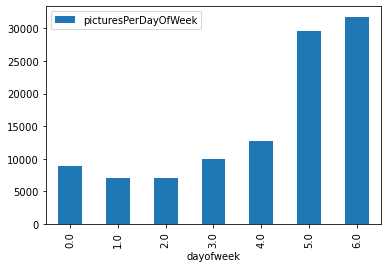

In [61]:
combine_all_data['dayofweek']=combine_all_data['Date'].dt.dayofweek
combine_all_data.groupby(['dayofweek']).agg(picturesPerDayOfWeek=('SourceFile','count')).plot(kind="bar")

In [62]:
df_no_home=combine_all_data[(combine_all_data['Place']!='Genf')& (combine_all_data['Place']!='Meyrin')
                            & (combine_all_data['Place']!='Lauchringen')
                            ].groupby(['year']).agg(DaysPerYear=('Day','nunique'),DaysInYear=('leapyear','median'))
df_no_home['DaysPerYearRatio']=df_no_home['DaysPerYear']/df_no_home['DaysInYear']
df_no_home.drop(columns=['DaysInYear'])

,DaysPerYear,DaysPerYearRatio
year,,
1996,0,0.000000
1997,0,0.000000
1998,0,0.000000
1999,0,0.000000
2000,0,0.000000
2001,0,0.000000
2002,0,0.000000
2003,0,0.000000
2004,0,0.000000


In [63]:
combine_all_data[combine_all_data['Date'].isna()][['SourceFile','Date','CreateDate']]

,SourceFile,Date,CreateDate
5530,/2009/090623 USA CTEQ09/090703 New York City/P...,NaT,NaN
18471,/2011/Lauchringen/P4240022-P420024 - Lauchring...,NaT,NaN
18510,"/2011/Private/PC310001 - Rust, Matthias im Eur...",NaT,NaN
53782,/2016/160910 Verbier & Hermence/P9110084 - Her...,NaT,NaN
53783,/2016/160910 Verbier & Hermence/P9110085 - Her...,NaT,NaN
...,...,...,...
108815,/2005/P050207 - Diavolezza/P2090005 - Diavolez...,NaT,NaN
108816,/2005/P050207 - Diavolezza/P2090007 - Diavolez...,NaT,NaN
108817,/2005/P050207 - Diavolezza/P2110002 - Diavolez...,NaT,NaN
108818,/2005/P050207 - Diavolezza/P2110006 - Diavolez...,NaT,NaN


<AxesSubplot:title={'center':'monthly count of  pictures'}, xlabel='Date', ylabel='picture count'>

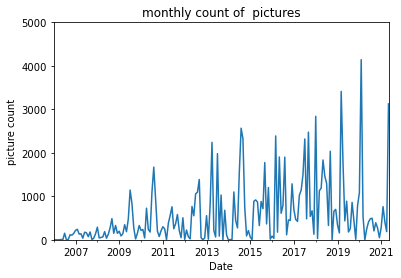

In [64]:
combine_all_data['Date']=pd.to_datetime(combine_all_data['Date'], utc=True)
#combine_all_data['Date'] = combine_all_data['Date'].dt.tz_localize(timezone.utc)
combine_all_data.groupby(pd.Grouper(key="Date", freq="M")).count()["SourceFile"].plot(title="monthly count of  pictures",ylabel="picture count",ylim=(0,5000))

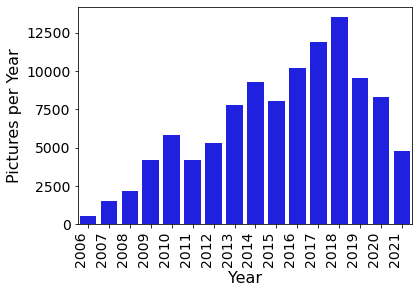

In [65]:
df_group=combine_all_data.groupby(pd.Grouper(key="Date", freq="Y")).count()["SourceFile"].reset_index()

ax = sns.barplot(x="Date", y="SourceFile", data=df_group,color = 'blue') 
x_dates = df_group['Date'].dt.strftime('%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right')
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('Pictures per Year',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

In [66]:
combine_all_data.groupby([combine_all_data["Date"].dt.hour]).count()

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day,leapyear,dayofweek
Date,,,,,,,,,,,,,,,,,,,,,
0.0,351,339,351,351,337,351,351,343,351,343,...,267,275,277,267,351,351,351,343,351,351
1.0,509,499,509,509,480,509,509,500,509,500,...,426,429,446,426,509,509,509,509,509,509
2.0,595,588,595,595,580,595,595,588,595,588,...,529,529,535,529,595,595,595,595,595,595
3.0,599,589,599,599,588,599,599,590,599,590,...,502,503,508,502,599,599,599,598,599,599
4.0,430,425,430,430,425,430,430,425,430,425,...,409,409,405,409,430,430,430,427,430,430
5.0,459,453,459,459,450,459,459,453,459,453,...,382,382,386,382,459,459,459,459,459,459
6.0,1001,988,1001,1001,936,1001,1001,988,1001,988,...,855,857,900,855,1001,1001,1001,983,1001,1001
7.0,2041,1987,2041,2041,1711,2041,2041,1991,2041,1991,...,1569,1573,1884,1569,2041,2041,2041,2023,2041,2041
8.0,4689,4604,4689,4689,3953,4689,4689,4605,4689,4605,...,3653,3654,4431,3653,4689,4689,4689,4667,4689,4689


In [67]:
test_sth=combine_all_data.groupby(combine_all_data["Date"].dt.dayofyear)[['SourceFile','Aperture']].count().sort_values(by=['SourceFile'], ascending=False)
test_sth

,SourceFile,Aperture
Date,,
250.0,1437,1415
249.0,1396,1378
251.0,1390,1374
252.0,1070,1059
207.0,948,914
...,...,...
67.0,1,1
102.0,1,0
122.0,1,1


In [68]:
test_sth=combine_all_data.groupby(combine_all_data["Date"].dt.date).agg(photosPerDay=('SourceFile','count'),
                                                                        countries=('Country','unique'),
                                                                        places=('Place','unique'),
                                                                        weekday=('dayofweek','mean')
                                                                       ).sort_values(by=['photosPerDay'], ascending=False)
test_sth.head(20)

,photosPerDay,countries,places,weekday
Date,,,,
2020-02-26,769,[Italy],[Florenz],2.0
2020-02-28,610,"[Vatican, Italy]",[Rom],4.0
2017-09-07,548,"[Italy, Vatican]",[Rom],3.0
2020-02-29,535,"[Italy, Vatican]",[Rom],5.0
2021-05-22,512,[Austria],"[Salzburg, Golling an der Salzach, Elsbethen]",5.0
2013-04-04,501,"[Vatican, Italy]",[Rom],3.0
2017-09-08,495,"[Italy, Vatican]",[Rom],4.0
2019-03-17,484,[Italy],"[Ercolano, Portici, Neapel]",6.0
2020-02-25,443,[Italy],"[Siena, Colle di Val d'Elsa, San Gimignano]",1.0


In [69]:
index_in=test_sth.index.values
range_in=list(range(1,367))

In [70]:
days_no_photos = set(index_in).symmetric_difference(set(range_in))
#days_no_photos

In [71]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains("Dom|Duomo|Cathedral|Kathedrale|cathedral")])

10914

In [72]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(r'(?=.*Koeln)(?=.*Dom)',regex=True)])

215

In [73]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Versailles)(?=.*Schloss)',regex=True)])

994

In [159]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Louvre)',regex=True)])

338

In [158]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Wien)(?=.*Hofburg)',regex=True)])

739

In [157]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Schoenbrunn)(?=.*Schloss)',regex=True)])

449

In [74]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Potsdam)(?=.*Sanssouci)',regex=True)])

713

In [75]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Kathedrale)(?=.*Genf)',regex=True)])

398

In [76]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Chapelle)(?=.*Paris)',regex=True)])

212

In [77]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Notre)(?=.*Paris)',regex=True)])

185

In [78]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Borghese)(?=.*Rom)',regex=True)])

187

In [79]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Maria Maggiore)(?=.*Rom)',regex=True)])

187

In [80]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Peter)(?=.*Rom)',regex=True)])

452

In [81]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Sagrada)(?=.*Barcelona)',regex=True)])

259

In [82]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Paris)(?=.*Saint)',regex=True)])

334

In [156]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*om)(?=.*Stephansdom)',regex=True)])

183

In [83]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*om)(?=.*Mailand)',regex=True)])

435

In [84]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Siena)(?=(.*Duomo|.*Dom))',regex=True)])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


335

In [85]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Palast|Chateau|Castle|Palace|Schloss|Residenz|Palazzo|Palais|palast|Reggia|Castelo|Burg|burg|Villa|Eremitage|Belvedere")])

30679

In [86]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rathaus|Hotel de Ville")])

1291

In [87]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Oper|Opera|Theatre|Teatro|heater|Staatsoper")])

1432

In [88]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Grotta|Grottes|Cave|Grotte|hoehle|Hoehle")])

1606

In [89]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Unter&Grindelwald&gletscher")])

0

In [90]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Mer de Glace")])

291

In [91]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "See|Lac|Lake|Lago")])

2598

In [92]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Grenzgletscher|Gornergletscher")])

209

In [93]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Mont Blanc")])

296

In [94]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Matterhorn")])

288

In [95]:
len(combine_all_data["SourceFile"][(combine_all_data["SourceFile"].str.contains(
    "Lateran")) & (~combine_all_data["SourceFile"].str.contains(
    "palast"))& (~combine_all_data["SourceFile"].str.contains(
    "Schatzkammer"))])

208

In [96]:
len(combine_all_data["SourceFile"][(combine_all_data["SourceFile"].str.contains(
    r'(?=.*Rom)(?=.*Palazzo Quirinale)',regex=True)) | (combine_all_data["SourceFile"].str.contains("Quirinals"))])

208

In [97]:
len(combine_all_data["SourceFile"][(combine_all_data["SourceFile"].str.contains(
    r"(?=.*)(?=.*Jungfraufirn)",regex=True))]) 

223

In [98]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r"(?=.*)(?=.*Aareschlucht)",regex=True)])

189

In [99]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Berlin)(?=.*Reichstag)',regex=True)])

50

In [100]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Gorge|Gorges|chlucht|Canyon|klamm")])

2189

In [101]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Neuschwanstein")])

101

In [102]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "fall|Falls|Cascade|foss|Ringquelle")])

1319

In [103]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "gletscher|Gletscher|Glacier|hiacciaio|Eismeer|firn|Plateau Rosa")])

5985

In [104]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Museo|Museum|museum|Uffizien|Museen|Eremitage|Louvre")])

4970

In [105]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    ", Aareschlucht")])

76

In [106]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Monet")])

73

In [107]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Goya")])

7

In [108]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Picasso")])

74

In [109]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rodin")])

33

In [110]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Dali")])

200

In [111]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Miro")])

33

In [112]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Gogh")])

24

In [113]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Chagall")])

32

In [114]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Kandinsky")])

23

In [115]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Max Ernst")])

13

In [116]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Brueghel")])

30

In [117]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Canova")])

33

In [118]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Michelangelo")])

63

In [119]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Raffael")])

112

In [120]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "da Vinci")])

42

In [121]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rembrandt")])

32

In [122]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Giotto")])

11

In [123]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rubens")])

88

In [124]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Botticelli")])

14

In [125]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Lippi")])

7

In [126]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Gauguin")])

12

In [127]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rothko")])

8

In [128]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Cezanne")])

17

In [129]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Giacometti")])

8

In [130]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Hodler")])

10

In [131]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Franz Marc")])

3

In [132]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Moschee|moschee/Cami")])

202

In [133]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "St Denis")])

119

In [134]:
#baroque
#Santa Maria Maggiore, Il Gesu, Sant'Ignazio, Theatinerkirche, Karlskirche, St Peter inside
#Santi Luca e Marina, Carlo alle Quattro Fontane, Andrea alla Quirinale, Louvre (Colonnade)
#Santa Maria della Salute, Sorbonne, Chateau de Maisons, Vaux-le-Vicomte, Palazzo Barberini, Versailles
#Louvre (part), Wuerzburg, Residenz Muenchen, Nymphenburg, Charlottenburg, Quirinale, Palazzo Pitti, 
#Passau, Salzburg, Caserta, Versailles, Naples, Schoenbrunn, Ludwigsburg, Mannheim, Rastatt
#Peter & Paul Krakow, Superga, Carignano, Madama, St Pauls, Greenwich Hospital, Blenheim Palace, Belvedere Vienna, 
#Clementinum Prague, Amalia Library, Santa Maria della Pace, Sapienza, Spanish Steps,Radcliffe Camera,
#Royal Palace Amsterdam, Palais Rohan, Poppelsdorf, Bonn, Benrath, Dresden (Innen)
#Hampton Court, Windsor Castle, Castle Howard, Chatsworth House, Castello del Valentino
#Lecce, Noto, Waldstein Palace, San Lorenzo Torino, Mafra Palace, Palazzo Reale Genua
#Aranjuez, Royal Palace Madrid, Schloss Eggenberg, Alte Residenz Salzburg, Het Loo Palace, Ksiaz Castle
#Torino, Venaria, Vaux-le-Vicomte, Winter Palace, Marinsky, Andre Kiev
#Puschkin, Peterhof, Peter & Paul Fortress, La Granja, Trevi Fountain, Cave Monastery Kiev
#Wilanow Palace, Zwinger, Frauenkirche, Pommersfelden, Goedoello, Fertoed
#Dome Invalides, Val de Grace, Drottningholm, Stockholm Palace, Fredensborg Palace, Amalienborg
#Tallin Catherinethal, Champs-sur-Marne

In [135]:
#gothic
#Westminster Abbey, "Westminster Hall","Old Hampton Court","old Eltham","old Hatfield","Stirling Castle","Conciergerie"
#Cathedral: Reims, Amiens, Orleans, Chartres, St Denis, Paris, Bourges, Strasbourg, Lyon
#Cathedral Canterbury, Chester, Glasgow, Edinburgh, Lincoln
#Duomo Milan, Siena, Hohensalzburg
#Dom Koeln, Frauenkirche, Regensburg, Stephansdom
#St Chapelle Paris, Vincennes, Christ Church College, King's College
#Scrovegni Chapel, Matthiaskirche, Kensington Palace
#Windsor Castle Church, Windsor Castle Church, Bath Abbey
#Prager Burg alt, Conciergerie, Vincennes
#Toledo, Segovia,Sevilla cathedrals, new cathedral Salamanca
#Maulbronn, Burgos Cathedral, Orvieto, St Maria sopra minerva
#Brussels Town Hall, La Llotja Valencia, Belfry Bruges
#Palais Papale, St Martin Landshut, Rouen, York Minster, Freiburg Minster, Ulm, Lorenz Nuernberg
#Brussels Cathedral, Antwerp Cathedral, Leuxen Town Hall, Mechelen Cathedral, Belfry Ghent, Albi Cathedral
#Palazzo Publico, Nieuwe Kerk Amsterdam, Wroclaw Town Hall, Mary Church, Krakow , Krakow Cathedral
#Faountains Abbey, Oranienbaum, Strelna, Palace of the Marquis of Dos Aguas, Skokloster, Dolmabahce
#Jeronimos Monastery, Leon, Avila, Valencia Cathedral, Bern Minster, Bodleian Library, St Mary Luebeck, Dom Schwerin, Luebeck

In [136]:
#classicism
#Wiesbaden, Chiswick House, Buckingham Palace, Capitol
#Petit Trianon, Chateau Bagatelle, Hotel de Salm, Compiegne, Academy Athens, Parliament Vienna, 
#Malmaison, Royal Palace Wroclaw, Menshikov, Stroganov
#Schloss Bellevue
#Isaac Cathedral, Pawlovsk, Gatchina, Somerset House, Budapest St Stephan, St Anna Warsaw, Prado,
#British Museum, Marmorpalais, Palaces on the Isle, Warsaw Royal Palace, Pantheon, Arc-et-Senans
#Palais Bourbon, Madelaine, Arc de Triomphe, 
#Galleria Borghese, Favorite Ludwigsburg, Wilhelmshoehe, Caserta, Capodimonte, 
#Kathedrale, Schlosskirche Kopenhagen,St Blasien
#Woerlitz, St Martin in the Fields, British Museum, Museumsinsel, Charlottenhof, Glienicke
#Glyptothek, Propylaeen, Koenigsbau Innen
#Brussels Royal Palace, Eisenstadt, Assisi Basilica, Santa Croce Florence, Palazzo Pitti (old quarters)

In [137]:
#romanesque
#Cathedral Rochester, Ely, Peterborough, Durham, Pisa, Worms, Mainz, Bamberg, Speyer, Limburg
#old Salamanca
#Hildesheim Michael, Cluny, Cloister Laterano, Cefalu, Palermo, Monreale
#Fontenay, St Savin
#Santa Maria in Cosmedin, Bitonton, Tower of London, Santiago de Compostela, Mt St Michel, Battistero Firenze, Cremona, Laterano
#Mt Saint-Michel, Vezelay, La Seu Lisbon, old Cathedral Coimbra, St Sernin, San Isidro Leon, Reichenau
#Arles, Trogir, Basel, Anagni crypt, Aquileia crypt, Bitonto, Molfetta, Trani, Bari Dom & Cathedral
#Castel del Monte, Wartburg, Rochester Castle, Canterbury Castle, Palazzo della Ragione Padua, Mantua, Genua
#Bayeux

In [138]:
#renaissance
#Hatfield House, Michaelskirche, Hofkirche Innsbruck, Palazzo Farnese, Sistine Chapel
#Blois, Chambord, Chenonceau, Fontainebleau, Louvre (Hof), Place des Voges, Amboise
#Palazzo Vecchio, Palazzo Ducale, Palazzo Te (Mantua), Palazzo Ducale (Venice), Laurentian Library Florence
#Hotel d'Assezat, St Eustache, St-Etienne-du-Mont, Certosa di Pavia, Scuola Grande di San Rocco
#Landshut Residenz, City Hall Bremen, Heidelberg, Rathaus Augsburg, Johannisburg Aschaffenburg
#Residenz Hof, City Hall Antwerp, Palazzo Schifanoia, Scuola Grande di San Marco
#University Salamanca, San Marco Leon, Charles V Alhambra, El Escorial, Granada Cathedral
#Villa Farnesina, Stanze Raffaele, Tempietto, Teatro Olympico, Villa Rotonda, Queen's House
#San Spirito, San Lorenzo, Palazzo Strozzi, Palazzo Medici Riccardi, Santa Maira Novella, Palazzo Rucellai
#Palazzo Ducale Urbino, Palazzo dei Diamanti, Santa Maria della Grazie, Prague Belvedere
#Banqueting Hall, Wawel Castle, Tomar Cloister, Belem Tower, Sao Roque, Frederiskborg, Pienza, Santa Maria degli Angeli Rome
#Kronborg, Rosenborg, Colleoni Chapel, Pazzi Chapel, Santa Maria della Pace, Ca d'Oro
#Biblioteca Marciana Venice, Basilica Palladiana (Vicenza), Cloth Hall Krakow, Concento San Esteban
#Gripsholm

In [139]:
#neobaroque

In [140]:
#neogothic
#"Votivkirche","Washington, National Cathedral", "NYC, St Patrick's Cathedral", "NYC, St John's Divine","Liverpool, Cathdral"
#Parlament London, Budapest, Strawberry Hill, Guildhall London

In [141]:
#rokoko
#Amalienburg, Sanssouci
#Wieskirche, Vierzehnheiligen
#Hotel Soubise, Hotel de Lassay, Hotel Matignon, Hotel de la Marine
#Ca Rezzonico, Wuerzburg Residenz, Solitude, Cuvilies, Augustusburg, Schaezlerpalais
#Queluz, Neues Schloss & eremitage Bayreuth, Bayreuth Theater
#Melk, Stupigini, Doria-Pamphilj, Katharinenschloss
#Bruchsal,Asamkirche, Seehof

In [142]:
#neoromanesque

In [143]:
#neorenaissance

In [144]:
#neobyzantine
#"Westminster Cathedral"

In [145]:
combine_all_data.head()

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,CreateDate,Date,ExposureTime,FileName,Flash,...,ColorTempAsShot,FlashActivity,ShutterSpeedValue,WB_RGGBLevelsAsShot,Country,Province,State,Day,leapyear,dayofweek
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:11:39,2006-11-25 13:11:39+00:00,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,France,France,2006-11-25,365,5.0
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006:11:24 13:12:06,2006-11-25 13:12:06+00:00,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,France,France,2006-11-25,365,5.0
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4.0,8.0,sRGB,Normal,2006:11:24 13:28:05,2006-11-25 13:28:05+00:00,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,365,5.0
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:12,2006-11-25 13:47:12+00:00,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,365,5.0
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4.0,8.0,sRGB,Normal,2006:11:24 13:47:23,2006-11-25 13:47:23+00:00,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",...,NaN,NaN,NaN,NaN,France,Haute-Savoie,Auvergne-Rhone-Alpes,2006-11-25,365,5.0


In [146]:
combine_all_data[combine_all_data['Country']=='Switzerland'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Geneve,5139
1,Wallis,4153
2,Bern,1897
3,Vaud,1019
4,Zuerich,563
5,Neuchatel,383
6,Switzerland,336
7,Appenzell Innerrhoden,292
8,Basel-Stadt,253
9,St Gallen,235


In [147]:
combine_all_data[combine_all_data['Country']=='Germany'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Baden-Wuerttemberg,5240
1,Bayern,4074
2,Berlin,1266
3,Sachsen,1027
4,Brandenburg,855
5,Hessen,751
6,Niedersachsen,670
7,Nordrhein-Westfalen,484
8,Thueringen,406
9,Sachsen-Anhalt,404


In [148]:
combine_all_data[combine_all_data['Country']=='Italy'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Lazio,4765
1,Campania,3351
2,Toscana,2756
3,Veneto,1979
4,Lombardia,1865
5,Sicilia,1325
6,Piemonte,921
7,Puglia,675
8,Emilia-Romagna,657
9,Umbria,632


In [149]:
combine_all_data[combine_all_data['Country']=='France'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Ile-de-France,5827
1,Auvergne-Rhone-Alpes,3242
2,Centre-Val de Loire,1059
3,Provence-Alpes-Cote d'Azur,781
4,Occitanie,616
5,Bourgogne-Franche-Comte,475
6,Nouvelle-Aquitaine,420
7,Normandie,354
8,Champagne-Ardenne,323
9,Grand Est,302


In [150]:
combine_all_data[combine_all_data['Country']=='Spain'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Catalonia,1475
1,Castilla y Leon,1042
2,Andalucia,880
3,Madrid,847
4,Valencia,286
5,Castile-La Mancha,220
6,Cantabria,186
7,Aragon,183
8,Galicia,140
9,Asturias,110


In [151]:
combine_all_data[combine_all_data['Country']=='Italy'].groupby(
    by=['Province']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerProvince"}).reset_index()[['Province','PicsPerProvince']]

,Province,PicsPerProvince
0,Roma,4636
1,Napoli,2245
2,Florenz,1845
3,Venezia,1347
4,Milano,874
5,Torino,852
6,Siena,728
7,Palermo,621
8,Genova,520
9,Salerno,404


In [152]:
combine_all_data[combine_all_data['Country']=='France'].groupby(
    by=['Province']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerProvince"}).reset_index()[['Province','PicsPerProvince']]

,Province,PicsPerProvince
0,Paris,3766
1,Haute-Savoie,2152
2,Yvelines,1097
3,Seine-et-Marne,678
4,Ain,627
5,Cher,397
6,Bouches-du-Rhone,353
7,Lyon,344
8,Champagne,323
9,Vaucluse,296


In [153]:
combine_all_data[combine_all_data['Country']=='Spain'].groupby(
    by=['Province']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerProvince"}).reset_index()[['Province','PicsPerProvince']]

,Province,PicsPerProvince
0,Barcelona,1212
1,Madrid,847
2,Sevilla,324
3,Segovia,310
4,Valencia,286
5,Cordoba,283
6,Salamanca,259
7,Granada,246
8,Toledo,220
9,Burgos,197


In [154]:
combine_all_data[combine_all_data['Country']=='Switzerland'].groupby(
    by=['State']).sum().reset_index().shape

(24, 20)

In [155]:
combine_all_data[combine_all_data['Country']=='Austria'].groupby(
    by=['State']).count().sort_values(by=['SourceFile'],ascending=False).rename(
    columns={"SourceFile": "PicsPerState"}).reset_index()[['State','PicsPerState']]

,State,PicsPerState
0,Wien,3299
1,Salzburg,611
2,Niederoesterreich,585
3,Tirol,424
4,Oberoesterreich,242
5,Steiermark,232
6,Burgenland,80
7,Austria,30
8,Vorarlberg,9
